In [85]:
import pandas as pd
import numpy as np
import math
import operator
import MySQLdb
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from statsmodels.stats import weightstats
from statsmodels import api as sm
from PyAstronomy import pyasl
import itertools
from itertools import combinations as cmb

import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# Load brain gene expression data 

print('Loading the data...\n')

gene_exp = pd.read_csv('brain_gene_normCountsNonZero_selected55.tsv', delimiter = '\t', header = 0)
print('gene_exp: Done')

# Load phenotype data

phen = pd.read_csv('GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt',delimiter = '\t', header = 0)
print('phen: Done')

# Load attributes data

attr = pd.read_csv('GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',delimiter = '\t', header = 0)
print('attr: Done')

# Load STR genotypes data

STR = pd.read_csv('STRs_genotypes.txt', delimiter = '\t', header = 0)
print('STR: Done')

Loading the data...

gene_exp: Done
phen: Done
attr: Done
STR: Done


In [87]:
# Check what is in the data and whether there are missing values:
# For expression data

print('Printing out top 5 records of loaded gene_exp table and its shape parameters:\n')
print('gene_exp.head()', gene_exp.head())
print('gene_exp.shape', gene_exp.shape)
print('\n')
print('Checking whether there are missing values in gene_exp table:')
print(np.where(pd.isnull(gene_exp)==1))

Printing out top 5 records of loaded gene_exp table and its shape parameters:

gene_exp.head()                  Name  GTEX-1117F-3226-SM-5N9CT  GTEX-111FC-3126-SM-5GZZ2  \
0  ENSG00000186487.17               1933.664132               4495.116727   
1  ENSG00000179915.22               3806.993988               7010.676630   
2  ENSG00000115310.17              18077.534194              37501.942667   
3  ENSG00000115353.10                 48.465239                199.478418   
4  ENSG00000153094.22                347.169366                370.024853   

   GTEX-111FC-3326-SM-5GZYV  GTEX-1128S-2726-SM-5H12C  \
0               4873.503205               4589.654121   
1               6734.764628               8982.444832   
2              26398.938994              33609.792594   
3                  0.000000                175.676317   
4                185.456968                398.140798   

   GTEX-1128S-2826-SM-5N9DI  GTEX-117XS-3026-SM-5N9CA  \
0               4974.671685               

In [88]:
# No values are missing; genes accession numbers are at 0th column,and each sample's data are in its separate column

# Tranpose the table, so that the samples are organized horizontally, while the genes are in columns each

print('Transposing gene_exp table...')
gene_exp = gene_exp.transpose()
gene_exp.columns = gene_exp.iloc[0,:]  # adjust columns names
gene_exp = gene_exp.drop(['Name'])
print('Done')

# Scale the data (by columns: subtract mean, divide by std), printout top 5 records

print('Scaling gene_exp data...(generating table gene_e)')
scaler = StandardScaler()
gene_e = pd.DataFrame(scaler.fit_transform(gene_exp), columns = list(gene_exp.columns), index = list(gene_exp.index))
print('Done\n')
print('Printing out 5 top records of scaled gene_e table:\n')
print('gene_e.head()', gene_e.head())

Transposing gene_exp table...
Done
Scaling gene_exp data...(generating table gene_e)
Done

Printing out 5 top records of scaled gene_e table:

gene_e.head()                           ENSG00000186487.17  ENSG00000179915.22  \
GTEX-1117F-3226-SM-5N9CT           -0.885577           -0.699002   
GTEX-111FC-3126-SM-5GZZ2            0.016525            0.216283   
GTEX-111FC-3326-SM-5GZYV            0.149787            0.137456   
GTEX-1128S-2726-SM-5H12C            0.049820            0.779613   
GTEX-1128S-2826-SM-5N9DI            0.185416            0.024830   

                          ENSG00000115310.17  ENSG00000115353.10  \
GTEX-1117F-3226-SM-5N9CT           -1.402232           -0.590750   
GTEX-111FC-3126-SM-5GZZ2            0.120308           -0.122479   
GTEX-111FC-3326-SM-5GZYV           -0.749977           -0.741034   
GTEX-1128S-2726-SM-5H12C           -0.184770           -0.196286   
GTEX-1128S-2826-SM-5N9DI           -1.081303           -0.737272   

                         

c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [89]:
# For phenotype data

print('Printing out top 5 records of loaded phen table and its shape parameters:\n')
print('phen.head()', phen.head())
print('phen.shape', phen.shape)

# Set the subjects ID ('SUBJID') as index in phen table to ease the transfer of data into gene_e
phen = phen.set_index('SUBJID')

# Missing values will be checked after transferral of relevant data (SEX, AGE, DEATH HARDNESS = DTHHRDY) into gene_e

Printing out top 5 records of loaded phen table and its shape parameters:

phen.head()        SUBJID  SEX    AGE  DTHHRDY
0  GTEX-1117F    2  60-69      4.0
1  GTEX-111CU    1  50-59      0.0
2  GTEX-111FC    1  60-69      1.0
3  GTEX-111VG    1  60-69      3.0
4  GTEX-111YS    1  60-69      0.0
phen.shape (980, 4)


In [90]:
# For attributes table (attr)

print('Printing out top 5 records of loaded attr table and its shape parameters:\n')
print(attr.head())
print(attr.shape)

# Set the sample ID ('SAMPID') as index in attr table to ease the transfer of data into gene_e
attr = attr.set_index('SAMPID')

# Missing values will be checked after transferral of relevant data (tissue=SMTSD, technology used to analyze DNA/RNA 
# =SMGEBTCHT, RNA measure of quality = SMRIN, total ischemic time for a samle = SMTSISCH) into gene_e

Printing out top 5 records of loaded attr table and its shape parameters:

                          SAMPID  SMATSSCR SMCENTER SMPTHNTS  SMRIN   SMTS  \
0       GTEX-1117F-0003-SM-58Q7G       NaN       B1      NaN    NaN  Blood   
1       GTEX-1117F-0003-SM-5DWSB       NaN       B1      NaN    NaN  Blood   
2       GTEX-1117F-0003-SM-6WBT7       NaN       B1      NaN    NaN  Blood   
3  GTEX-1117F-0011-R10a-SM-AHZ7F       NaN   B1, A1      NaN    NaN  Brain   
4  GTEX-1117F-0011-R10b-SM-CYKQ8       NaN   B1, A1      NaN    7.2  Brain   

                          SMTSD  SMUBRID  SMTSISCH  SMTSPAX  ... SME1ANTI  \
0                   Whole Blood  0013756    1188.0      NaN  ...      NaN   
1                   Whole Blood  0013756    1188.0      NaN  ...      NaN   
2                   Whole Blood  0013756    1188.0      NaN  ...      NaN   
3  Brain - Frontal Cortex (BA9)  0009834    1193.0      NaN  ...      NaN   
4  Brain - Frontal Cortex (BA9)  0009834    1193.0      NaN  ...      N

In [91]:
# For STR genotypes table

print('Printing out top 5 records of loaded STR table and its shape parameters:\n')
print(STR.head())
print(STR.shape)

# Generate index column, derived from Sample IDs (Sample column) to ease the transfer of data into gene_e

for i in range(len(STR)):
    STR.loc[i, 'sample_index'] = STR.loc[i,'Sample'].split('-')[0]+'-'+STR.loc[i,'Sample'].split('-')[1]

STR = STR.set_index('sample_index')

# Missing values will be checked after the data are transfered into gene_e

Printing out top 5 records of loaded STR table and its shape parameters:

                     Sample  STR_1  STR_2 STR_3  STR_4 STR_5  STR_6  STR_7  \
0  GTEX-1117F-0003-SM-6WBT7   6/11  26/26   8/8  38/40  8/25  36/36  12/35   
1  GTEX-111CU-0003-SM-6WBUD   6/15  16/19   6/6  38/40  7/16  36/36  12/24   
2  GTEX-111FC-0001-SM-6WBTJ    6/6  15/16  6/14  38/38   7/9  36/37  10/24   
3  GTEX-111VG-0004-SM-6WBTS   6/13  16/17   5/6  43/47   6/7  33/39  24/24   
4  GTEX-111YS-0004-SM-6WBTN  14/23  15/16   6/6  40/41  7/14  39/41   7/12   

  STR_8 STR_9 STR_10 STR_11 STR_12 STR_13 STR_14 STR_15  
0  7/33  7/33   9/37  23/30    6/9    1/6  11/11  13/13  
1  5/19  7/20   8/37  22/28    7/9   4/12  14/14  14/14  
2  6/19  6/20   6/41  23/31    7/9   1/12  13/13  13/13  
3  8/19  7/20   7/40  21/27    7/7   3/10  14/14  14/14  
4  5/19   1/6   9/38  19/26    7/9   1/10  10/10    8/8  
(652, 16)


In [92]:
# Extend gene_e table by adding columns from phen,attr and STR tables 

print('Extending gene_e table by additional information from phen,attr and STR tables...')
for ind in gene_e.index:
    sample_id = ind.split('-')[0]+'-'+ind.split('-')[1]
    
    gene_e.loc[ind,'sex'] = phen.loc[sample_id,'SEX']  # transfering data from phen into gene_e
    gene_e.loc[ind,'age'] = phen.loc[sample_id,'AGE'] 
    gene_e.loc[ind,'dthhrdy'] = phen.loc[sample_id,'DTHHRDY']
    
    gene_e.loc[ind,'tissue'] = attr.loc[ind, 'SMTSD']  # transfering data from attr into gene_e
    gene_e.loc[ind,'smgebtcht'] = attr.loc[ind,'SMGEBTCHT']
    gene_e.loc[ind,'smrin'] = attr.loc[ind,'SMRIN']
    gene_e.loc[ind,'smtsisch'] = attr.loc[ind,'SMTSISCH']
    
    for one_str in list(STR.columns)[1:]:   # transfering data from STR into gene_e; full genotype per STR locus,
                                        # largest allele of two and the average of two 
            
        gene_e.loc[ind, one_str] = STR.loc[sample_id, one_str]
        
        set_of_vals = []
        for value in gene_e.loc[ind, one_str].split('/'):
            if value != '.':
                set_of_vals.append(int(value))
        if len(set_of_vals) == 2:
             AverageOfTwo = sum(set_of_vals)/2
        elif len(set_of_vals) == 1:
             AverageOfTwo = sum(set_of_vals)
        elif len(set_of_vals) == 0: 
            continue
            
        gene_e.loc[ind,'LargeOfTwo_'+one_str] = max(set_of_vals)
        gene_e.loc[ind,'AverageOfTwo_'+one_str] = AverageOfTwo    
print('Done\n')
    
# Print out all age categories in gene_e
print('Printing out all age categories in gene_e for subsequent conversion into numerical groups:')
print(np.unique(list(gene_e['age'].values)))
print('\n')

age_old = np.unique(list(gene_e['age'].values))  # Map age categories into numeric values (n'th decade)
age_new = []

for age_range in age_old:
    age_new.append(int(age_range[0]))
age_map = dict(zip(age_old, age_new))
print('Printing out values for conversion across age groups:')
print(age_map)
gene_e['age'] = gene_e['age'].map(age_map)  

Extending gene_e table by additional information from phen,attr and STR tables...
Done

Printing out all age categories in gene_e for subsequent conversion into numerical groups:
['20-29' '30-39' '40-49' '50-59' '60-69' '70-79']


Printing out values for conversion across age groups:
{'20-29': 2, '30-39': 3, '40-49': 4, '50-59': 5, '60-69': 6, '70-79': 7}


In [93]:
# Check whether there are missing values in a final gene_e table

print('Checking whether there are missing values in a final gene_e table:\n')
rows, cols = np.where(pd.isnull(gene_e))  
print(rows,cols)

Checking whether there are missing values in a final gene_e table:

[] []


Checking that all samples in gene_e are matched in smgebtcht (technolofy used for RNA analysis):
All samples have been analysed by one technology: TruSeq.v1


Checking whether there are outliers in smrin (RNA quality)...
Generating plots of smrin values distribution:



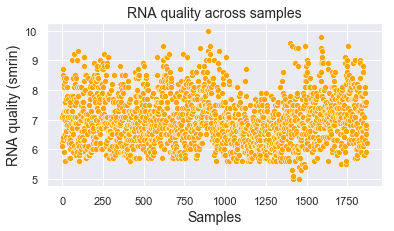

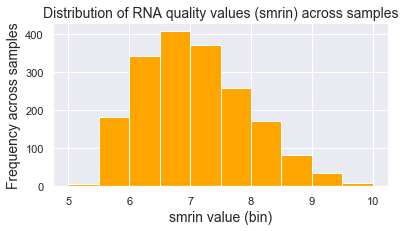

In [94]:
# Check that smgebtcht and smrin are uniform across samples, as these 
# technical parameters may affect measured gene expression

# Check that all samples in gene_e are matched in smgebtcht (technolofy used for RNA analysis)

print('Checking that all samples in gene_e are matched in smgebtcht (technolofy used for RNA analysis):')

if len(np.unique(list(gene_e['smgebtcht'].values))) > 1:
    print('There are more than 1 technology used for RNA analysis: {}'.format(np.unique(list(gene_e['smgebtcht'].values))))
    print('\n')
else:
    print('All samples have been analysed by one technology: {}'.format(np.unique(list(gene_e['smgebtcht'].values))[0]))
    print('\n')
# Check there are no outliers in smrin (RNA quality) 

print('Checking whether there are outliers in smrin (RNA quality)...')
print('Generating plots of smrin values distribution:\n')

plt.figure(figsize = (6,3))
sns.scatterplot(x = range(0,len(gene_e)), y = 'smrin', data = gene_e, color ='orange')
plt.xlabel('Samples', fontsize = 14)
plt.ylabel('RNA quality (smrin)', fontsize =14)
plt.title('RNA quality across samples', fontsize =14)
plt.show()

plt.figure(figsize = (6,3))
plt.hist(gene_e['smrin'].values, bins = 10, color = 'orange', edgecolor='w')
plt.xlabel('smrin value (bin)',fontsize =14)
plt.ylabel('Frequency across samples',fontsize =14)
plt.title('Distribution of RNA quality values (smrin) across samples', fontsize = 14)
plt.show()

In [95]:
# All smrin values are distributed between 5 and 10; check for outliers:
# (type of distribution (normal/not-normal) is to be determined first)

print('Checking type of smrin values distribution:')
stat, pval = stats.shapiro(list(gene_e['smrin'].values))
if pval > 0.05:  # if P-value > 0.05 H0 of distribution normalty is accepted
    print('SMRIN values are normally distributed, Shapiro test P-value: ', pval)
    print('\n')
    # apply Generalized Extreme Studentized Deviate (ESD) test for outliers if distribution is normal;
    # scatter plot above shows that all values are between 5 and 10, and there are few (<15) close to boundaries
    
    print('Outliers in the distribution: {}'.format(pyasl.generalizedESD(list(gene_e['smrin'].values), maxOLs = 15, 
                                                                         alpha = 0.05))) 
    
else: # if P-value < 0.05 H0 of distribution normalty is rejected
    print('SMRIN values are not normally distributed, Shapiro test P-value: ', pval)
    print('\n')
    
    # apply Interquartile range (IQR) - based test to find outliers in non-normally distributed set
    
    Q1 = np.percentile(list(gene_e['smrin'].values), 25)
    Q3 = np.percentile(list(gene_e['smrin'].values), 75)
    IQR = Q3-Q1  # InterQuartile range
    inner_fence = IQR*1.5
    outer_fence = IQR*3
    suspected_outliers = gene_e[(gene_e['smrin'] < Q1 - inner_fence) | (gene_e['smrin'] > Q3 + inner_fence)].index
    strong_outliers = gene_e[(gene_e['smrin'] < Q1 - outer_fence) | (gene_e['smrin'] > Q3 + outer_fence)].index
    
    print('suspected_outliers',suspected_outliers)
    print('strong_outliers',strong_outliers)

Checking type of smrin values distribution:
SMRIN values are not normally distributed, Shapiro test P-value:  9.908316131272948e-17


suspected_outliers Index(['GTEX-15EO6-0011-R11b-SM-6M47M', 'GTEX-N7MS-2526-SM-2D7W3',
       'GTEX-T5JC-0011-R11A-SM-32PMB'],
      dtype='object')
strong_outliers Index([], dtype='object')


In [96]:
# Check what are the smrin values, suspected to be outliers:

print('Printing out smrin values, suspected to be outliers:\n')
for ind in suspected_outliers:
    print(ind, ":", gene_e.loc[ind,'smrin'])  

Printing out smrin values, suspected to be outliers:

GTEX-15EO6-0011-R11b-SM-6M47M : 10.0
GTEX-N7MS-2526-SM-2D7W3 : 9.6
GTEX-T5JC-0011-R11A-SM-32PMB : 9.8


In [97]:
# Conclusion: all suspected outliers are those with rather extremely high quality of RNA, so no reason to 
# exclude these samples 

# Data complexity reduction for further analysis of relationships between various features and gene expression

Generating Elbow plot for optimal PC number choice:



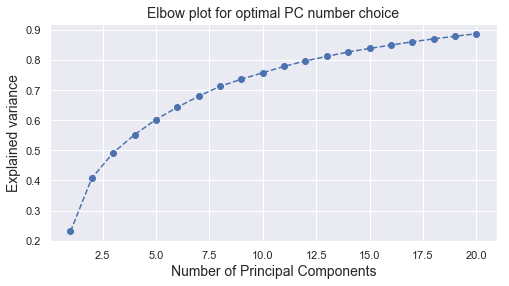

In [98]:
# Reduce dimensionality of gene expression by Principal Component Analysis

sns.set()
pca_obj = PCA(n_components = 20)  # try up to 20 PCs to see how much variance is covered 
pca_obj.fit(gene_e[list(gene_e.columns)[0:55]])  # plug in only columns with numerical data 

# Elbow plot to decide how many PCs will suffice

print('Generating Elbow plot for optimal PC number choice:\n')
explained_variance_fractions = []
for p in range(1,21):
    explained_variance_fractions.append(sum(pca_obj.explained_variance_ratio_[:p]))
plt.figure(figsize =(8,4))    
plt.plot(range(1,21), explained_variance_fractions, marker = 'o', linestyle = '--')
plt.xlabel('Number of Principal Components', fontsize = 14)
plt.ylabel('Explained variance', fontsize = 14)
plt.title('Elbow plot for optimal PC number choice', fontsize = 14)
plt.show()
    

In [99]:
# Interpretation: PCs number of 8 will be taken (though this isn't a strong elbow point and would cover only ~71% 
# of variance.

print('Reduction of gene expression data (55) genes into 8 principal components...')
pca_obj = PCA(n_components = 8)  
pca_obj.fit(gene_e[list(gene_e.columns)[0:55]])  # plug in only columns with numerical data 
gene_pca = pd.DataFrame(pca_obj.transform(gene_e[list(gene_e.columns)[0:55]]), 
                        columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],
                        index = gene_e.index)  
print('Done')
gene_e = pd.concat([gene_pca, gene_e], axis=1)  # place 8 columns of Principal Components into original gene_e table


Reduction of gene expression data (55) genes into 8 principal components...
Done


# Q1: Find genes whose expression clusterizes the samples by tissues most (find out what PCs separate samples by tissue, and then what genes are contributing to these PCs most)

Generating plots for gene expression by PCs combinations:



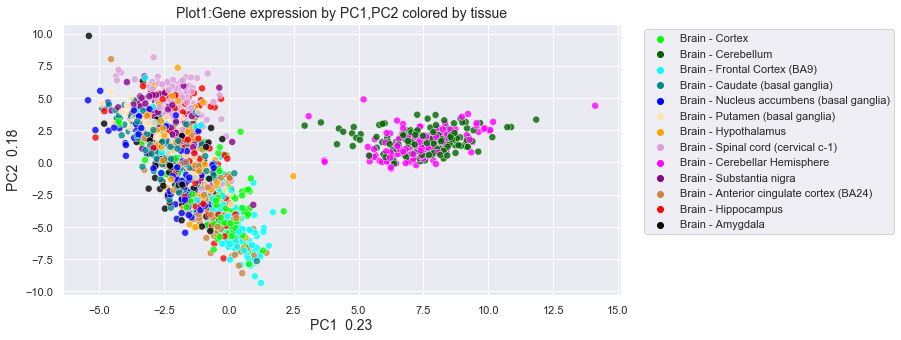

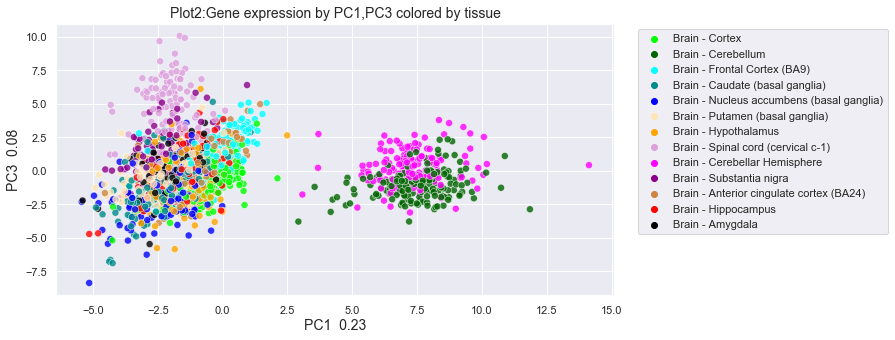

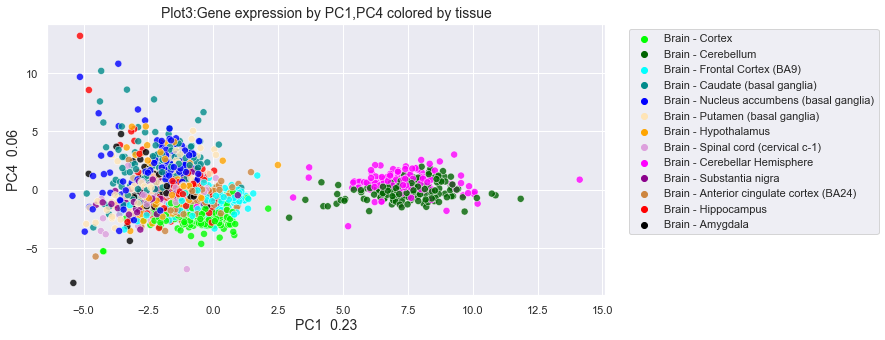

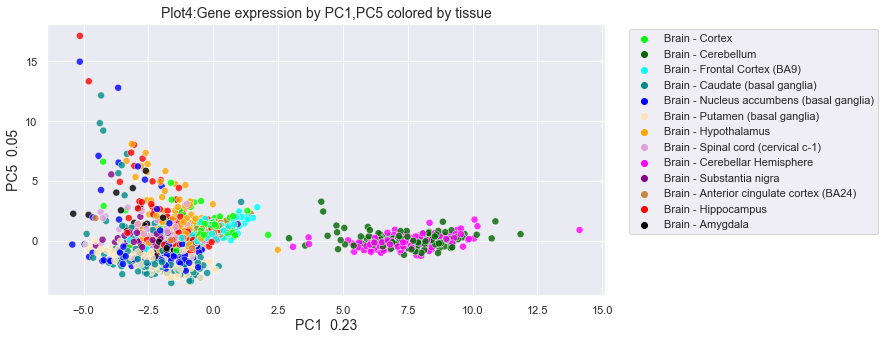

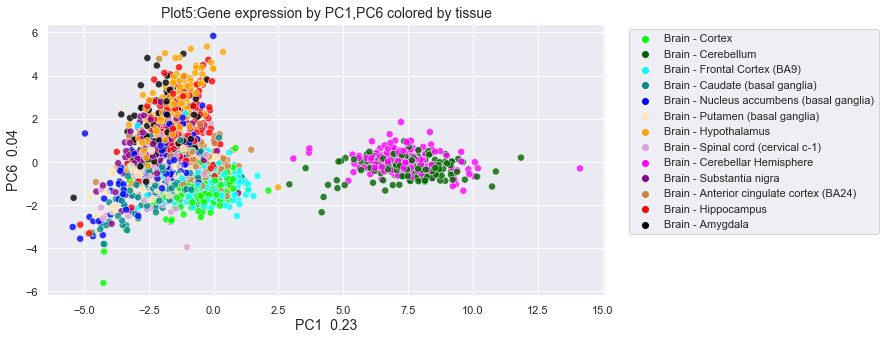

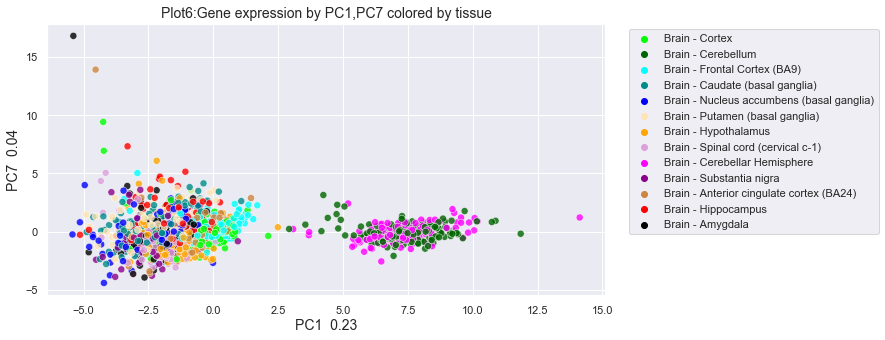

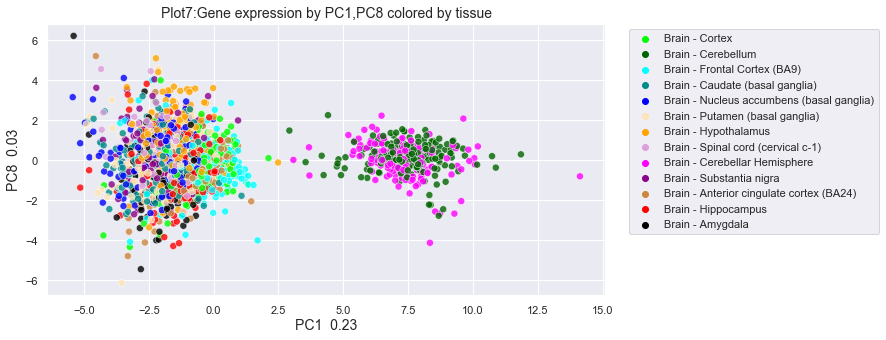

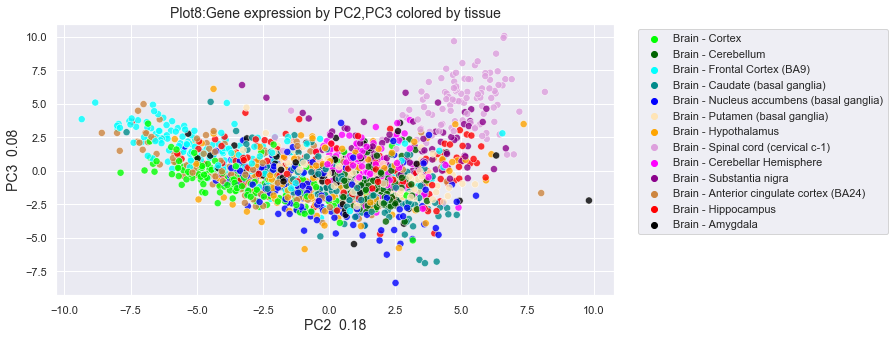

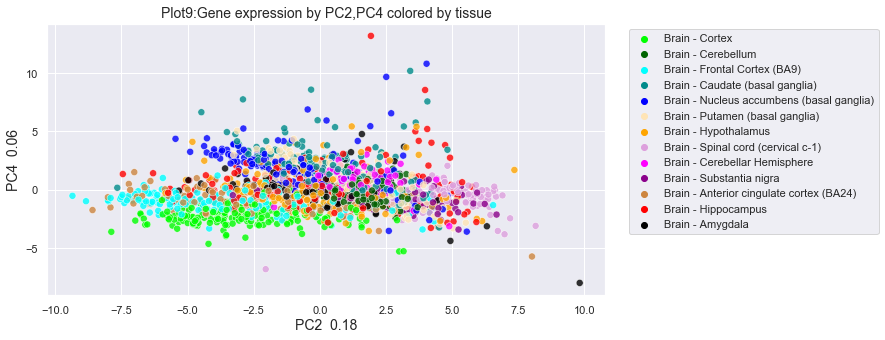

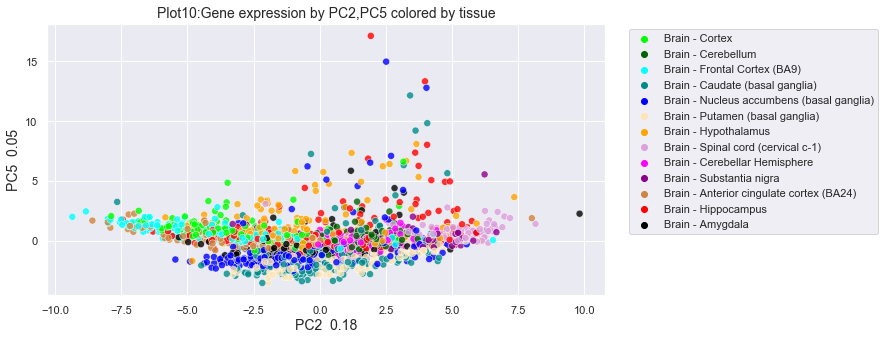

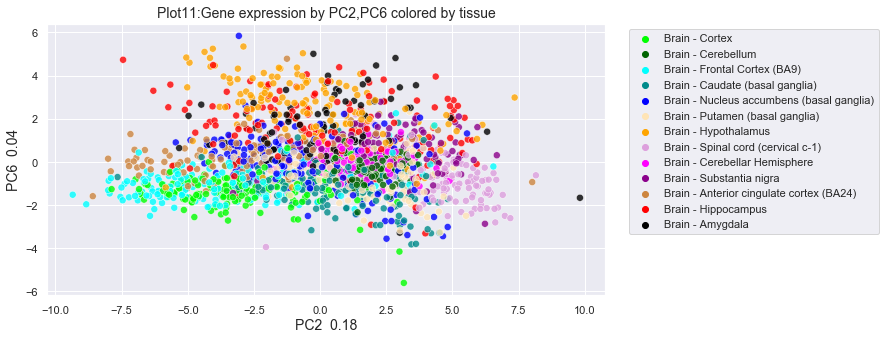

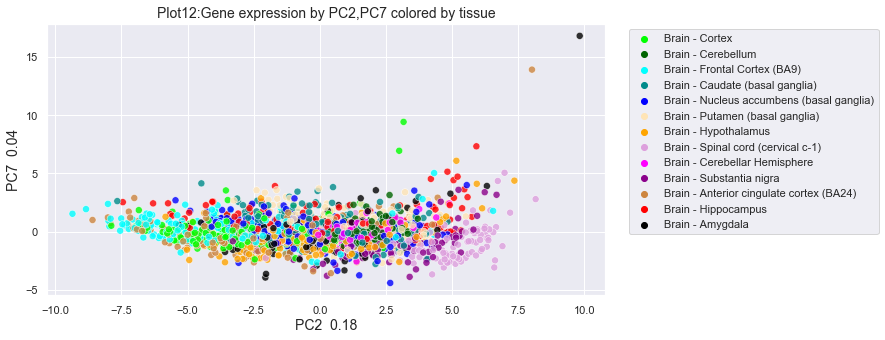

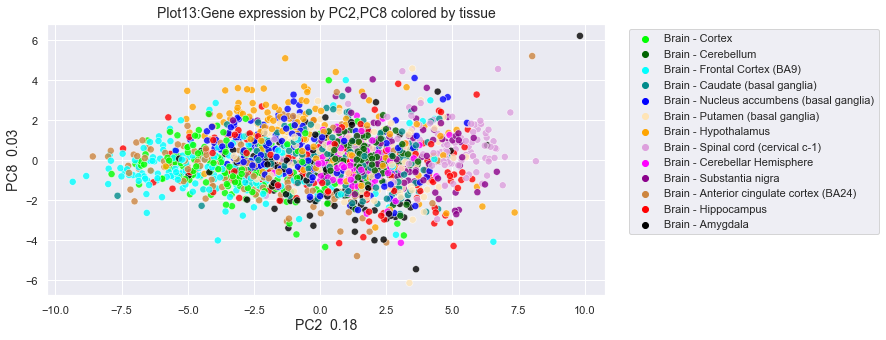

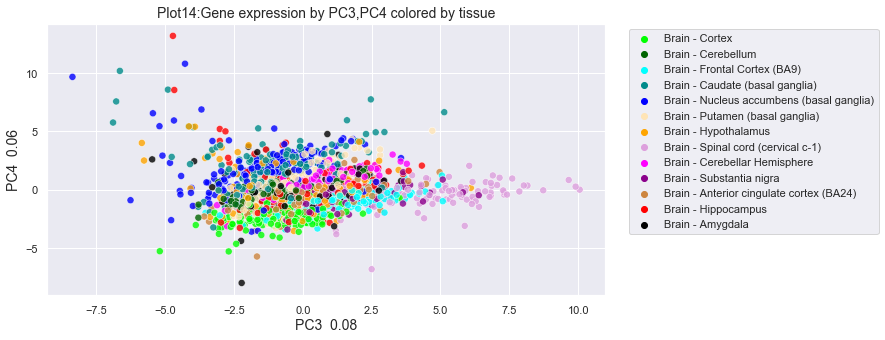

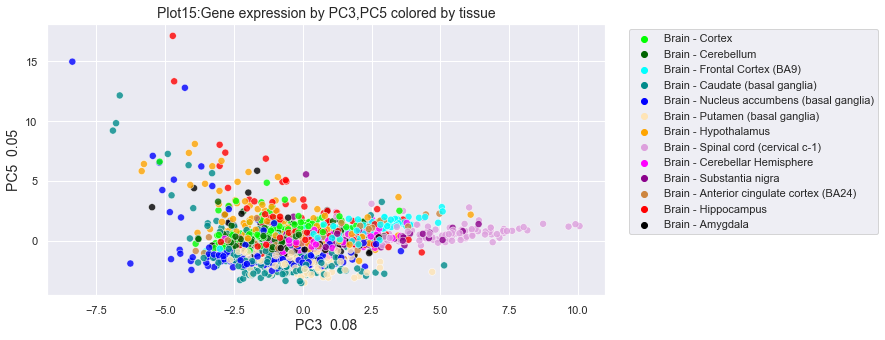

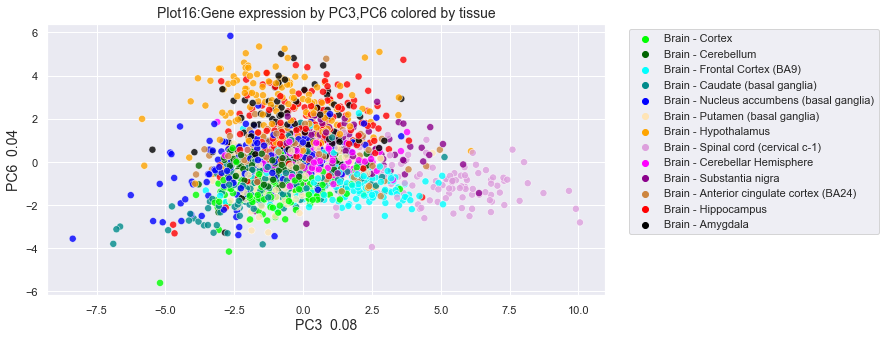

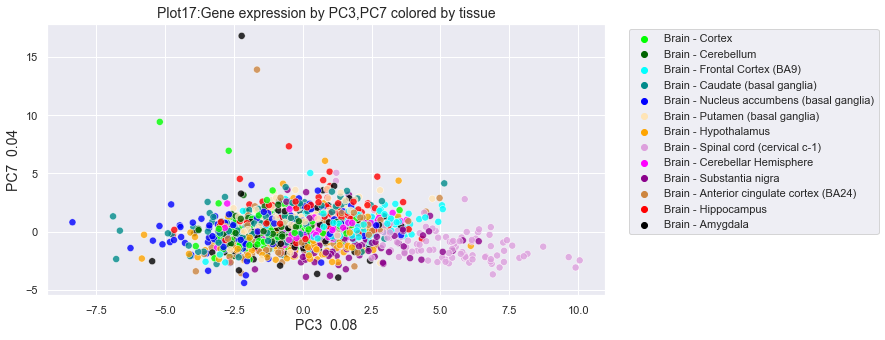

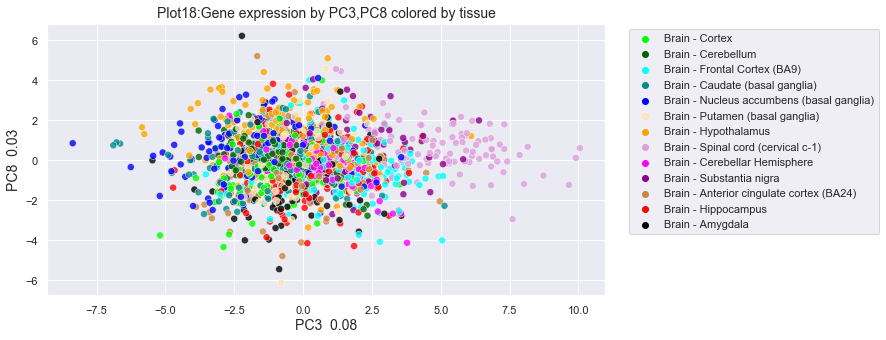

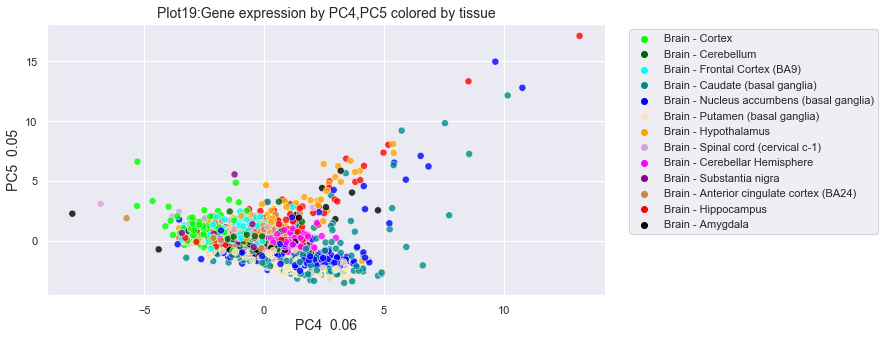

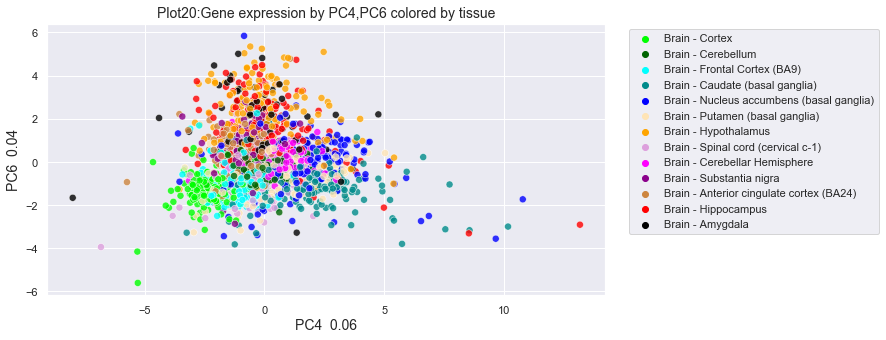

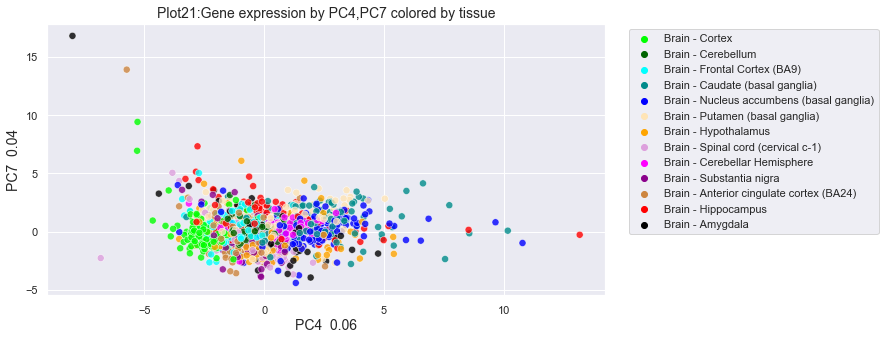

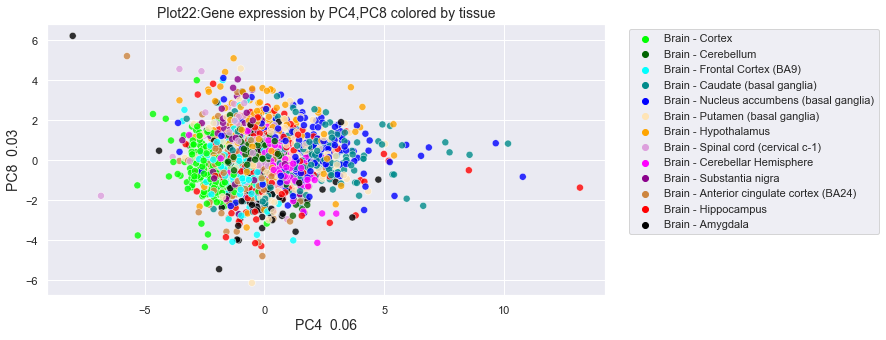

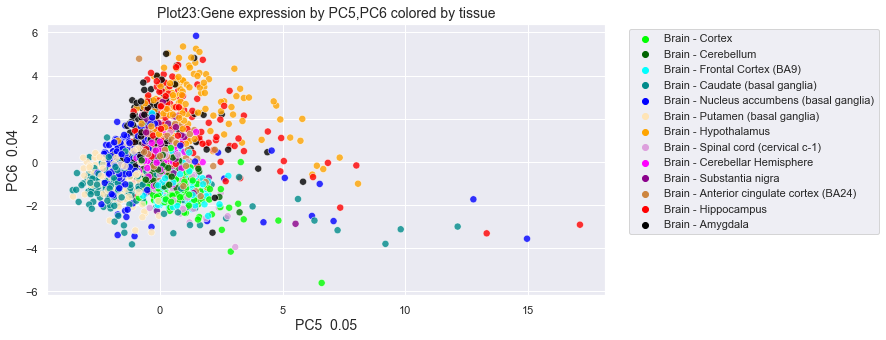

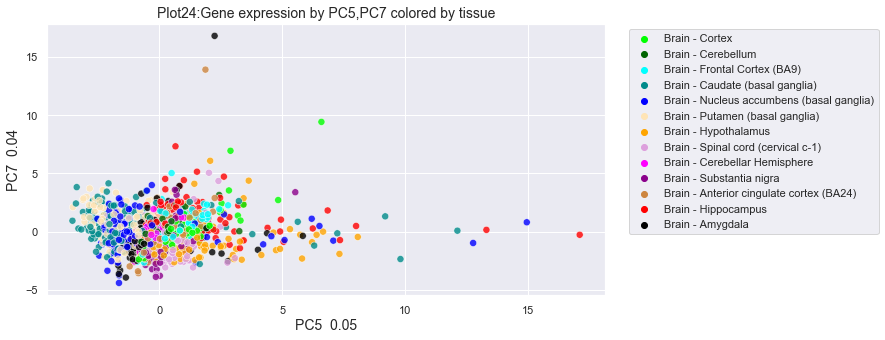

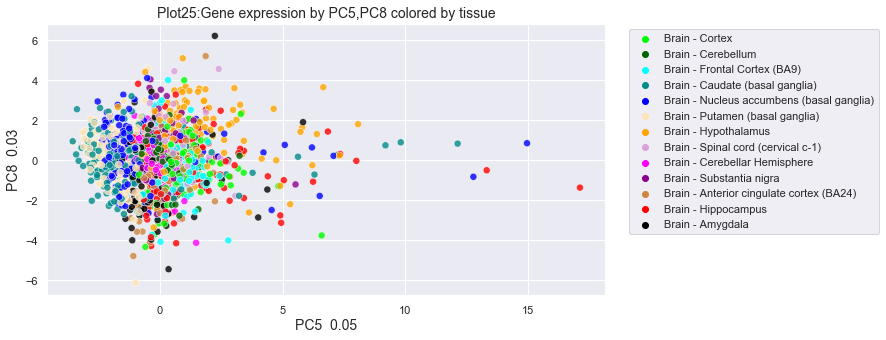

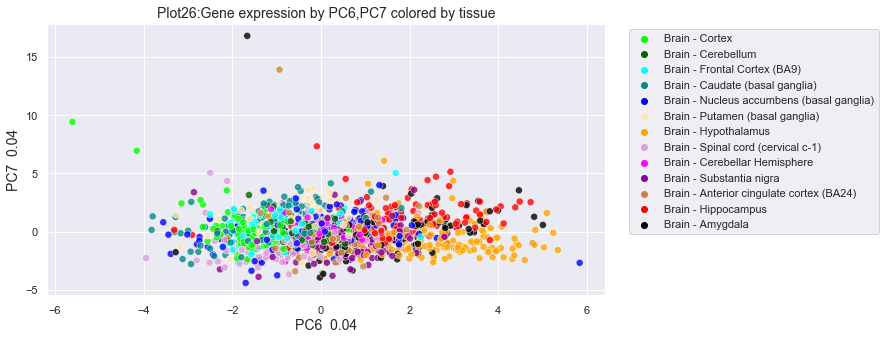

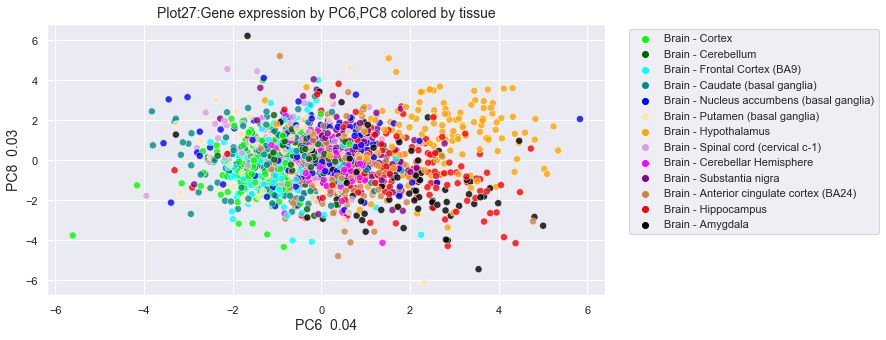

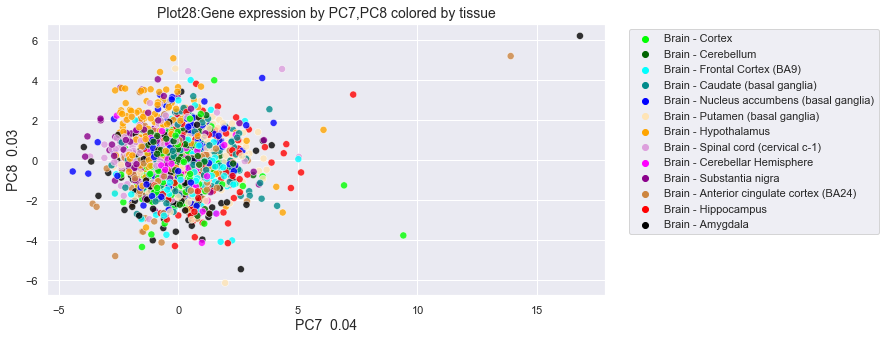

In [100]:
# plot Gene expression by PCs combinations, highlight tissues
pcs_combinations = list(cmb(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'], 2)) # generate all possible combinations
                                                                                   # of 2 PCs out of 8 

cust_palette = ['lime','darkgreen','cyan','darkcyan', 'blue',
              'moccasin', 'orange', 'plum', 'magenta', 'darkmagenta',
              'peru', 'red', 'black']  

print('Generating plots for gene expression by PCs combinations:\n')
graph_count = 1
for pcs_set in pcs_combinations:
    pcs_set0_num = int(pcs_set[0].replace('PC',''))-1  # for subsequent retrieval of explained variance
    pcs_set1_num = int(pcs_set[1].replace('PC',''))-1  
    
    sns.set()
    plt.figure(figsize = (10,5))
    sns.scatterplot(x = pcs_set[0], y = pcs_set[1], data = gene_e, 
                    hue = 'tissue', 
                    palette = cust_palette, alpha = 0.8, s = 50)
    plt.xlabel(pcs_set[0]+'  {}'.format(round(pca_obj.explained_variance_ratio_[pcs_set0_num],2)), fontsize = 14)
    plt.ylabel(pcs_set[1]+'  {}'.format(round(pca_obj.explained_variance_ratio_[pcs_set1_num],2)), fontsize = 14)
    plt.title('Plot'+str(graph_count)+':Gene expression by '+ pcs_set[0]+','+pcs_set[1]+' colored by tissue', fontsize = 14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    graph_count += 1
    plt.show()

In [101]:
# Interpretation:

# Cerebellum/Cerebellar hemisphere datapoints are most segregated to the right by PC1 (Plot1, x axis)
# Cortex, Frontal Cortex and anterior cingulate cortex are most segregated by PC4,PC2 (Plot9, y,x axes) 
# Caudate, Nucleus Accumbens and Putamen are most segregated by PC8,PC5 (Plot25, y,x axes)
# Hypothalamus, Hippocampus and Amygdala are most segregated by PC7,PC6 (Plot26, y,x axes)
# Spinal Cord, Substancia Nigra are most segregated by PC7,PC3 (Plot17, y,x axes)

In [103]:
# Display genes, that are most correlated with the separating PCs across tissues
# Use mySQL query to retrive gene names via gene accession number

tissue_PCs = {'Cerebellum':['PC1'], 'Cortex':['PC4','PC2'],'Basal_ganglia':['PC8','PC5'],
              'Hippocampus_Amygdala_Hypothalamus': ['PC7','PC6'], 'SpinalCord_SubstanciaNigra':['PC7','PC3']}

components = pca_obj.components_  # an array of 16 arrays, each containing correlation coefficients of this component
                                  # with original genes  

list_genes = list(gene_e.columns)[8:63]

db = MySQLdb.connect(host = 'genome-mysql.soe.ucsc.edu', 
                     user = 'genomep',password = 'password',
                     database = 'hg19')   # mySQL database of UCSC genome browser for gene names retrieval
cur = db.cursor()  

print('Printing out genes, that are most correlated with the separating PCs across tissues:\n')
for key, val in tissue_PCs.items():
    print('For ',key, ':')
    for PC in val:
        comp_num = int(PC.replace('PC','')) - 1
        
        corr_coeffs = components[comp_num]  # pull coefficients per component of interest
        ori_CoeffGene = dict(zip(list_genes,corr_coeffs))
        
        abs_CoeffGene = dict(zip(list_genes,np.abs(corr_coeffs)))
        sorted_abs_CoeffGene = dict(sorted(abs_CoeffGene.items(), key = operator.itemgetter(1), reverse=True)) 
        
        print('5 most defining genes per component ', PC, ' are:')
        for gene in list(sorted_abs_CoeffGene.keys())[:5]:
            cur.execute("SELECT t2.value FROM ensGene t left join \
            ensemblToGeneName t2 on t.name = t2.name WHERE %s = name2", [gene.split('.')[0]])
            rs = cur.fetchall()
            gene_name = np.unique(list(rs))
            print(gene, '(',gene_name[0],')', ': ', round(ori_CoeffGene[gene],2))
    print('\n')
db.close()

Printing out genes, that are most correlated with the separating PCs across tissues:

For  Cerebellum :
5 most defining genes per component  PC1  are:
ENSG00000064309.14 ( CDON ) :  0.26
ENSG00000151849.14 ( CENPJ ) :  0.26
ENSG00000112139.14 ( MDGA1 ) :  0.26
ENSG00000104885.17 ( DOT1L ) :  0.24
ENSG00000107643.15 ( MAPK8 ) :  0.24


For  Cortex :
5 most defining genes per component  PC4  are:
ENSG00000152582.13 ( SPEF2 ) :  0.3
ENSG00000039139.9 ( DNAH5 ) :  0.27
ENSG00000030304.13 ( MUSK ) :  0.27
ENSG00000148660.20 ( CAMK2G ) :  -0.26
ENSG00000123454.10 ( DBH ) :  -0.25
5 most defining genes per component  PC2  are:
ENSG00000067191.15 ( CACNB1 ) :  -0.29
ENSG00000162105.17 ( SHANK2 ) :  -0.28
ENSG00000221866.9 ( PLXNA4 ) :  -0.27
ENSG00000186487.17 ( MYT1L ) :  -0.24
ENSG00000169032.9 ( MAP2K1 ) :  -0.24


For  Basal_ganglia :
5 most defining genes per component  PC8  are:
ENSG00000165280.15 ( VCP ) :  0.43
ENSG00000166225.8 ( FRS2 ) :  -0.4
ENSG00000150275.17 ( PCDH15 ) :  -0.31
E

# Q2: Explore relationship between gene expression, given as 8 PCs, and features: sex, age, death hardness (dthhrdy), ischemic time (smtsisch)

Generating heatmap plots for Pearson correlation between PCs and features of interest:



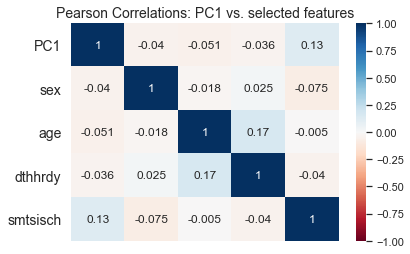

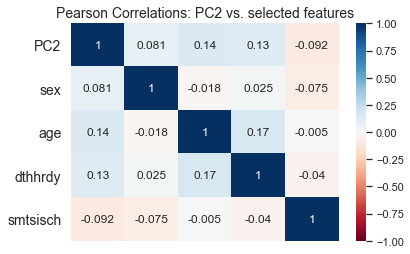

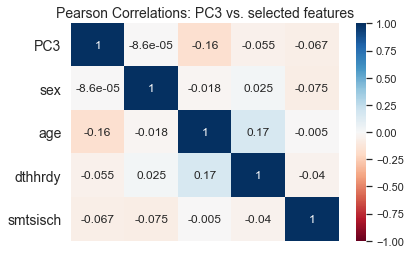

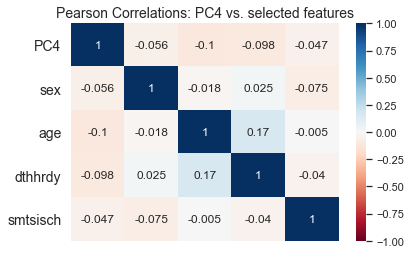

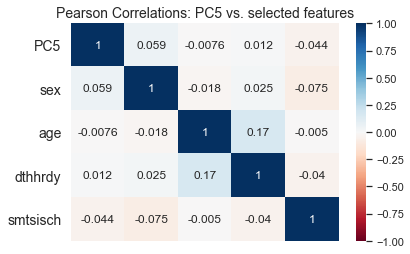

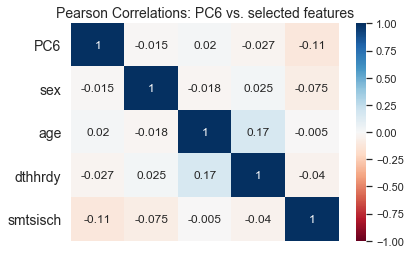

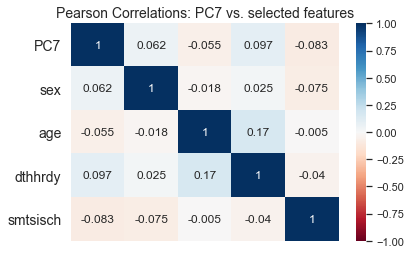

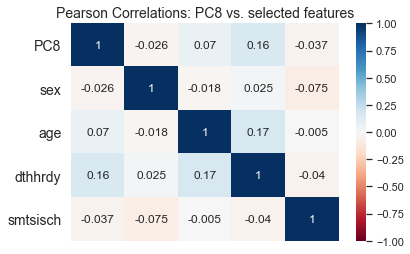

In [104]:
# Generate heatmaps of Pearson correlations b/w PC of interest and features of interest

print('Generating heatmap plots for Pearson correlation between PCs and features of interest:\n')
for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    
    sns.heatmap(gene_e[[pc,'sex','age','dthhrdy','smtsisch']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = False, vmin = -1, vmax = 1)
    plt.yticks(fontsize = 14, rotation = 0)
    plt.title('Pearson Correlations: '+ pc + ' vs. selected features', size = 14)
    plt.show()    
    

In [105]:
# Interpretation:
# sex has weak negative correlation with 3 PCs, weak positive correlation with 4 PCs and negligible negative
# correlation with 1 PC (PC3). Further exploration will follow since we still don't know whether correlations have
# significant P-values.

# age has weak negative correlation with 5 PCs, weak positive correlations with 2 PCs and negligible negative 
# correlation with 1 PC (PC5).  Relationships of age and gene expression will be further explored later.

# death hardness has weak negative correlation with 5 PCs and weak positive correlation with 3 PCs. Further 
# exploration will follow.

# ischemic time has weak negative correlation with 6 PCs and weak positive correlation with 2 PCs. Further 
# exploration will follow.  


# Q2-a: Is differential gene expression associated with gender?

Plotting gene expression by principal components 1,2:



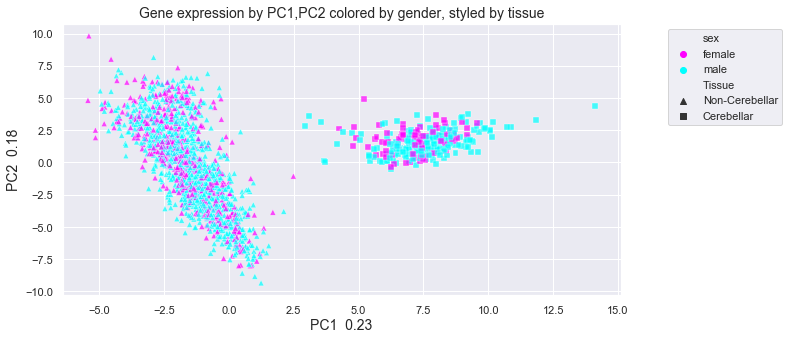

In [106]:
# Plot gene expression across samples by PC1,2 highlighting gender groups; show tissues as two major clusters:
# cerebellar, non-cerebellar

print('Plotting gene expression by principal components 1,2 wigh highlighted genders:\n')
gene_e['sex'] = gene_e['sex'].map({1:'male', 2:'female'})  # Convert numeric gender identifications into verbal   

for ind in gene_e.index:
    if gene_e.loc[ind,'tissue'] ==  'Brain - Cerebellum' or  gene_e.loc[ind,'tissue'] == 'Brain - Cerebellar Hemisphere':
        gene_e.loc[ind,'Tissue'] = 'Cerebellar'  # add an additional column with tissues being classified as 
                                                 # Cerbellar and Non-Cerebellar
    else:
        gene_e.loc[ind,'Tissue'] = 'Non-Cerebellar'

sns.set()
plt.figure(figsize = (10,5))
sns.scatterplot(x = 'PC1', y = 'PC2', data = gene_e, hue = 'sex', palette = ['magenta','cyan'],
               style = 'Tissue', markers = ['^','s'], alpha = 0.7, s = 35)
plt.xlabel('PC1  {}'.format(round(pca_obj.explained_variance_ratio_[0],2)), fontsize = 14)
plt.ylabel('PC2  {}'.format(round(pca_obj.explained_variance_ratio_[1],2)), fontsize = 14)
plt.title('Gene expression by PC1,PC2 colored by gender, styled by tissue', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

Generating boxplots for PC distributions across genders:



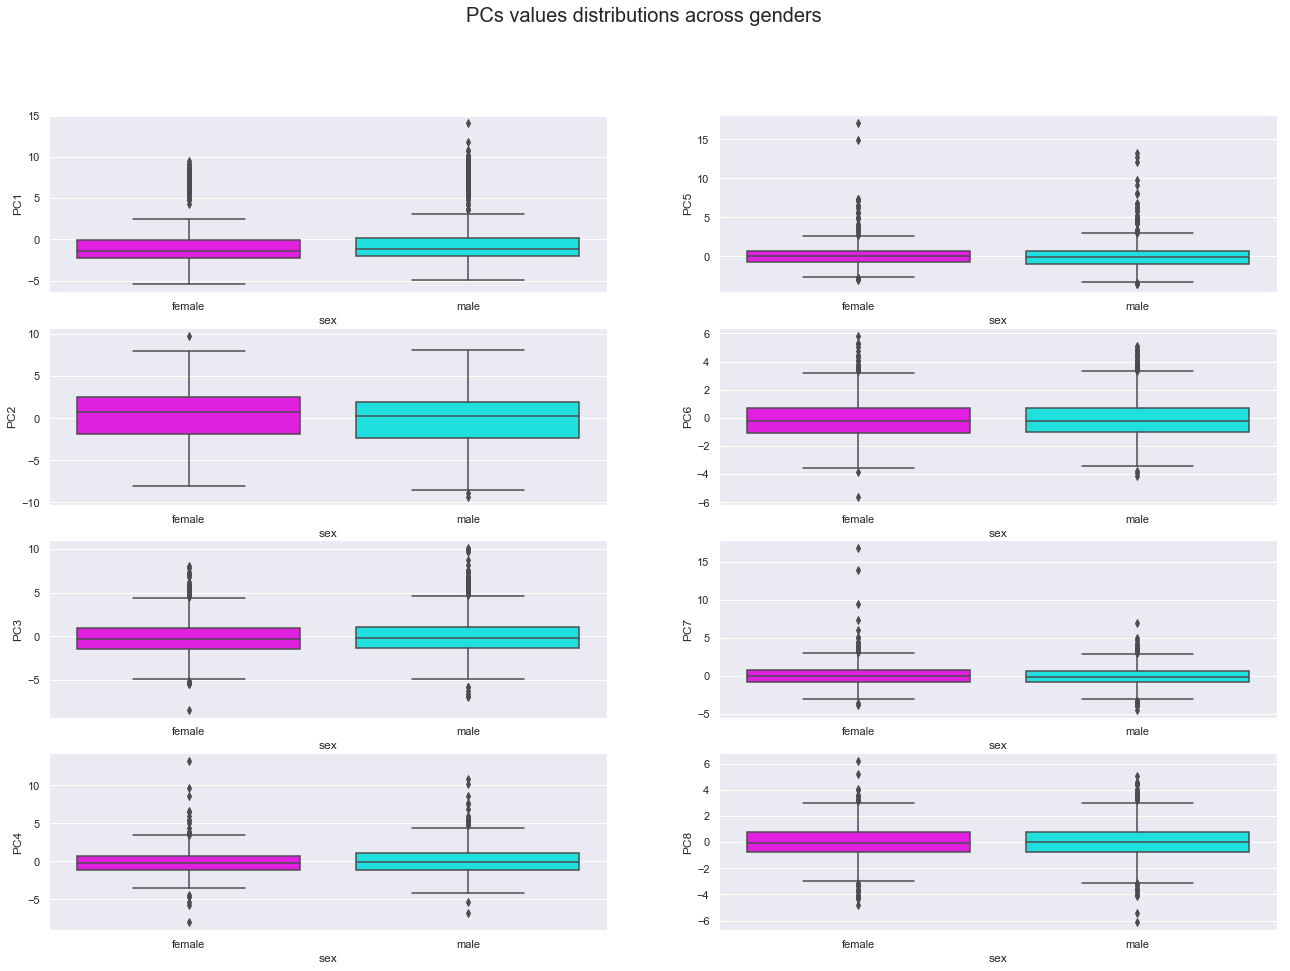

In [108]:
# Interpretation: there is no apparent clusterization of datapoints by gender, meaning that current PCs do not separate
# the data by gender. However, somewhat higher PC2 values may be suggested for females than for males, especially in 
# Cerebellar data; boxplots per PC, showhing PC's values distributions for males and females are necessary and/or 
# statistical comparisons of these distributions.

print('Generating boxplots for PC distributions across genders:\n')
fig, axes = plt.subplots(4,2, figsize = (22,15)) 
plt.suptitle('PCs values distributions across genders', fontsize = 20)
i,j = 0,0

for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    sns.boxplot(x = 'sex', y = pc, data = gene_e, palette = ['magenta','cyan'], ax = axes[i,j])
    i += 1 
    if pc == 'PC4':
        i = 0
        j = 1
    
plt.show()

In [115]:
# Interpretation: differential gene expression, reflected by all PCs except PC2 may not be associated with gender;  
# PC2 values distribution for females may be higher than for males. To test this assumption and to verify
# that other PC distributinos do not differ between genders, PCs distributions across genders will be compared. 

print('Checking PC distributions across genders for normality:\n')

comparisons = {}

for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    print('For ',pc,':')
    normality = 0
    gender_subsets = [list(gene_e[(gene_e['sex'] == 'female')][pc].values),
                      list(gene_e[(gene_e['sex'] == 'male')][pc].values)]
    d = 0
    for distri in gender_subsets:
        if d == 0:
            gender = 'females'
        else:
            gender = 'males'
        stat_shap, pval = stats.shapiro(distri)
        if pval > 0.5:
            status = 1
            print('For', gender, 'PC values are distributed normally; Shapiro test P-value: {}'.format(round(pval,5)))
        else:
            status = 0
            print('For', gender, 'PC values are not distributed normally; Shapiro test P-value: {}'.format(round(pval,5)))
        d +=1
        normality += status
    d = 0    
    if normality < 2:  # if any or both of the distributinos isn't normal, comparison is to be done by
                       # by Mann-Whitney U test 
        
        u, mw_pval = mannwhitneyu(list(gene_e[gene_e['sex'] == 'female'][pc].values), \
                                  list(gene_e[gene_e['sex'] == 'male'][pc].values), alternative = 'two-sided')
        median_diff = np.median(gene_e[gene_e['sex'] == 'female'][pc]) - \
        np.median(gene_e[gene_e['sex'] == 'male'][pc])
        
        if mw_pval < 0.05/8:  # Bonferonni correction: int otal 8 tests
            u, mw_less_pval = mannwhitneyu(list(gene_e[gene_e['sex'] == 'female'][pc].values), \
                                  list(gene_e[gene_e['sex'] == 'male'][pc].values), alternative = 'less')
            if mw_less_pval < 0.05:
                status = 'less'
                pval_adjusted = mw_less_pval
                
            else:
                u, mw_more_pval = mannwhitneyu(list(gene_e[gene_e['sex'] == 'female'][pc].values), \
                                  list(gene_e[gene_e['sex'] == 'male'][pc].values), alternative = 'greater')
                if mw_more_pval < 0.05:
                    status = 'greater'
                    pval_adjusted  = mw_more_pval
        else:
            status = 'equal'
            pval_adjusted = mw_pval
        
        comparisons[pc+'_f_m'] = ['mw', status, round(median_diff,3), round(pval_adjusted,5)]
        
    elif normality == 2:  #  both distributions are normal and can be compared by ztest
        
        zstat, z_pval = weightstats.ztest(gene_e[gene_e['sex'] == 'female'][pc], \
                                  gene_e[gene_e['sex'] == 'male'][pc], alternative = 'two-sided')
        mean_diff = np.mean(gene_e[gene_e['sex'] == 'female'][pc]) - \
        np.mean(gene_e[gene_e['sex'] == 'male'][pc])
        
        if z_pval < 0.05/8:  # Bonferonni correction: int otal 8 tests
            if zstat < 0:
                status = 'less'
                pval_adjusted = z_pval/2
            if zstat > 0:
                status = 'greater'
                pval_adjusted = z_pval/2
        else:
            status = 'equal'
            pval_adjusted = z_pval
        
        comparisons[pc+'_f_m'] = ['ztest', status, round(mean_diff,3), round(pval_adjusted,5)]
print('\n')
print("""Comparing PC distributions (by z test if normal or by Mann-Whitney U test if not normal);
      reporting type of test, comparison status, mean or median difference (for z test or Mann-Whitney U test,
     respectively), P-value\n""")
for key,val in comparisons.items():  # print out all comparisons results
    print(key,val)
        

Checking PC distributions across genders for normality:

For  PC1 :
For females PC values are not distributed normally; Shapiro test P-value: 0.0
For males PC values are not distributed normally; Shapiro test P-value: 0.0
For  PC2 :
For females PC values are not distributed normally; Shapiro test P-value: 0.00019
For males PC values are not distributed normally; Shapiro test P-value: 0.0
For  PC3 :
For females PC values are not distributed normally; Shapiro test P-value: 0.0
For males PC values are not distributed normally; Shapiro test P-value: 0.0
For  PC4 :
For females PC values are not distributed normally; Shapiro test P-value: 0.0
For males PC values are not distributed normally; Shapiro test P-value: 0.0
For  PC5 :
For females PC values are not distributed normally; Shapiro test P-value: 0.0
For males PC values are not distributed normally; Shapiro test P-value: 0.0
For  PC6 :
For females PC values are not distributed normally; Shapiro test P-value: 0.0
For males PC values are n

In [ ]:
# Conclusion: PC1 tend to be lower for females than for males (medians difference -0.177);
# PC2 values tend to be higher for females than for males (medians difference 0.504).
# Differential expression of other PCs does not seem to be gender-related. 

# Q2-b: Is differential gene expression associated with age?

Plotting gene expression by principal components 1,2 with highlighted age groups (2 = 20-29 years, 3 = 30-39 years etc.)


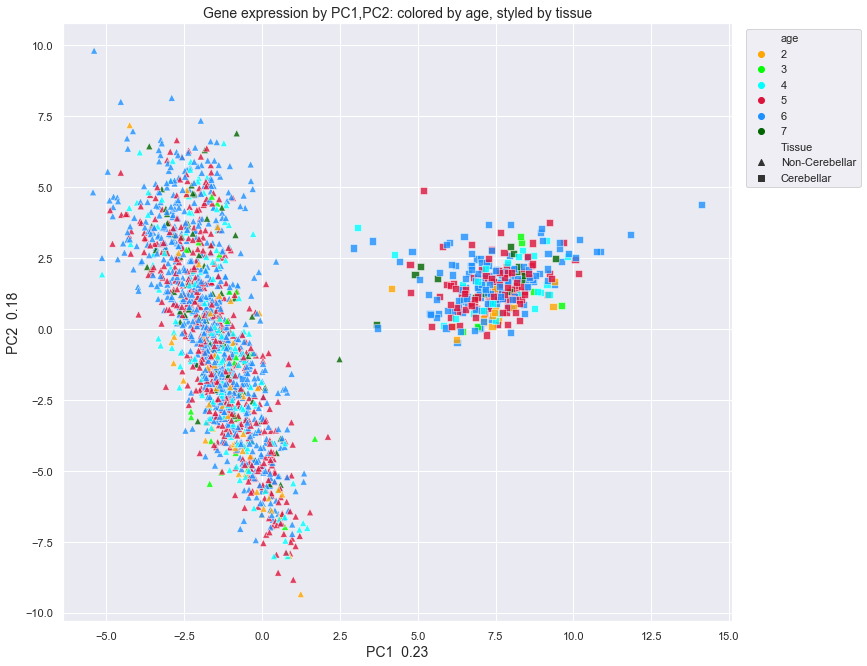

In [116]:
# Plot gene expression across samples by PC1,2 highlighting age groups; show tissues as two major clusters:
# cerebellar, non-cerebellar


print('Plotting gene expression by principal components 1,2 with highlighted age groups (2 = 20-29 years, 3 = 30-39 years etc.)')
sns.set()
plt.figure(figsize = (12,11))
sns.scatterplot(x = 'PC1', y = 'PC2', data = gene_e, 
                hue = 'age', palette = ['orange','lime','cyan','crimson','dodgerblue','darkgreen'],
                style = 'Tissue', markers = ['^','s'], alpha = 0.8, s = 50)
plt.xlabel('PC1  {}'.format(round(pca_obj.explained_variance_ratio_[0],2)), fontsize = 14)
plt.ylabel('PC2  {}'.format(round(pca_obj.explained_variance_ratio_[1],2)), fontsize = 14)
plt.title('Gene expression by PC1,PC2: colored by age, styled by tissue', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Generating boxplots showing PC distributions across age groups:



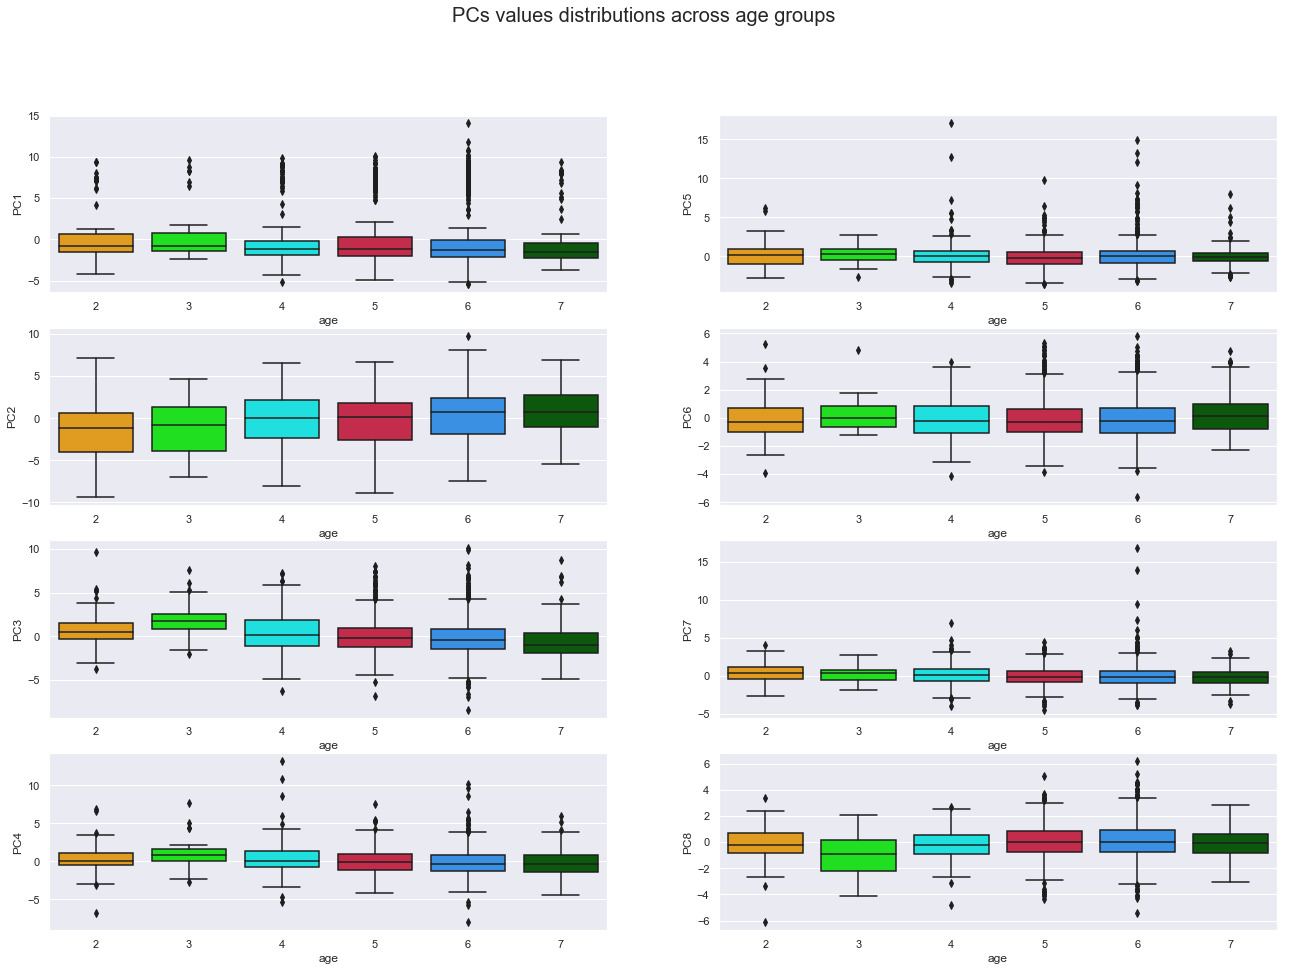

In [117]:
# Interpretation: no apparent clusterization by age is seen when data are plotted on PC1/PC2 axes, except that PC2
# might be separating datapoints of cerebellum (datapoints of age 2 are mostly concentrated at the lower 
# part of cerebellum-specific cluster, whereas datapoints of age 7 are mostly concentrated at the upper part).
# Boxplots per all PCs of interest, showing values distributions across age groups are to be generated.

print('Generating boxplots showing PC distributions across age groups:\n')
fig, axes = plt.subplots(4,2, figsize = (22,15)) 
plt.suptitle('PCs values distributions across age groups', fontsize = 20)
i,j = 0,0

for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    sns.boxplot(x = 'age', y = pc, data = gene_e, 
    palette = ['orange','lime','cyan','crimson','dodgerblue','darkgreen'],ax = axes[i,j])
    i += 1 
    if pc == 'PC4':
        i = 0
        j = 1
    
plt.show()

In [126]:
# Interpretation: there might be PCs with differential gene expression across age groups: PC2 tend to increase with age,
# while PC3 and to a lesser extent PC1 show mild decrease in values for older subjects;
# additionally, age group 7 (70-79 years) might have higher PC6 values than other age groups, and age group 3 
# (30-39 years) seem to have lower PC8 values comparing to other age groups. To verify these observations and to check 
# relationship between other PCs and age groups, P-values for Pearson correlations are to be calculated:

print("""Checking Pearson correlation P-values for PC of interest and age groups (both correlation coefficient 
      and P-value are shown):\n""")
for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    pear, pval = stats.pearsonr(list(gene_e['age'].values),list(gene_e[pc].values))
    if pval < 0.05/8:  # Bonferonni correction for P-value
        status= 'significant'
    else:
        status = 'non-significant'
    print('Correlation between', pc,'and age: coef=',round(pear,3),'P-value=', round(pval,6), '({})'.format(status))

Checking Pearson correlation P-values for PC of interest and age groups (both correlation coeficient 
      and P-value are shown):

Correlation between PC1 and age: coef= -0.051 P-value= 0.02678 (non-significant)
Correlation between PC2 and age: coef= 0.144 P-value= 0.0 (significant)
Correlation between PC3 and age: coef= -0.156 P-value= 0.0 (significant)
Correlation between PC4 and age: coef= -0.103 P-value= 8e-06 (significant)
Correlation between PC5 and age: coef= -0.008 P-value= 0.74275 (non-significant)
Correlation between PC6 and age: coef= 0.02 P-value= 0.395292 (non-significant)
Correlation between PC7 and age: coef= -0.055 P-value= 0.016875 (non-significant)
Correlation between PC8 and age: coef= 0.07 P-value= 0.002532 (significant)


In [127]:
# Conclusion: Age is positively correlated with PC2, PC8 and negatively correlated with PC3,PC4.

# Q2-c: Is differential gene expression associated with death hardness?

Plotting gene expression by principal components 1,2 with highlighted death hardness levels
(0 = on ventilator immediately before death; 1 = fast and violent death; 2 = fast, natural; 3 = intermediate; 4 = slow, after prolonged illness):



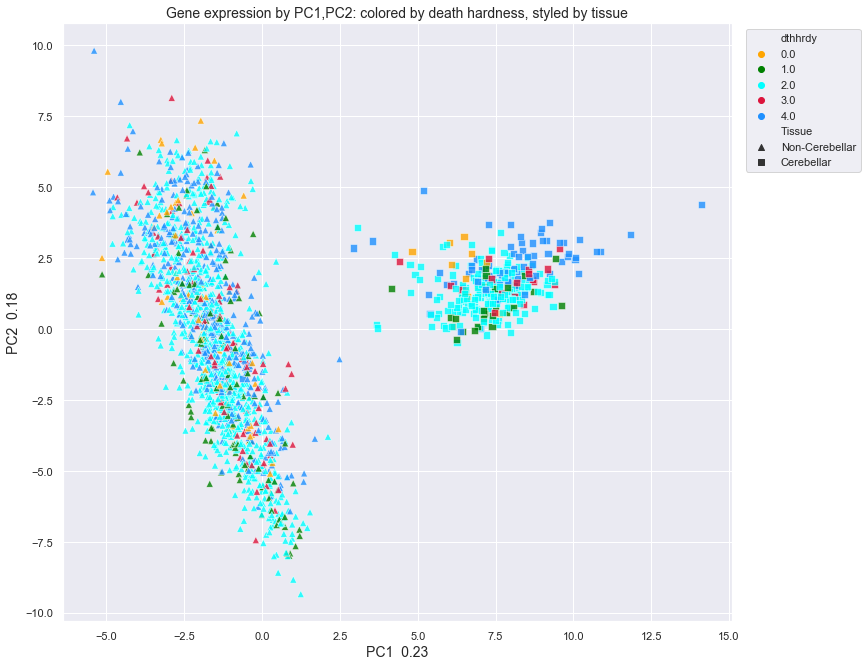

In [131]:
# Plot gene expression by PC1,2, highlight death hardness by color, style datapoints by tissues (Cerebellar/
# Non-Cerebellar)

print("""Plotting gene expression by principal components 1,2 with highlighted death hardness levels
(0 = on ventilator immediately before death; 1 = fast and violent death; 2 = fast, natural; 3 = intermediate; 4 = slow, after prolonged illness):\n""")
sns.set()
plt.figure(figsize = (12,11))
sns.scatterplot(x = 'PC1', y = 'PC2', data = gene_e, 
                hue = 'dthhrdy', palette = ['orange','green','cyan','crimson','dodgerblue'],
                style = 'Tissue', markers = ['^','s'], alpha = 0.8, s = 50)
plt.xlabel('PC1  {}'.format(round(pca_obj.explained_variance_ratio_[0],2)), fontsize = 14)
plt.ylabel('PC2  {}'.format(round(pca_obj.explained_variance_ratio_[1],2)), fontsize = 14)
plt.title('Gene expression by PC1,PC2: colored by death hardness, styled by tissue', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Generating boxplots for PC distributions across death hardness levels:



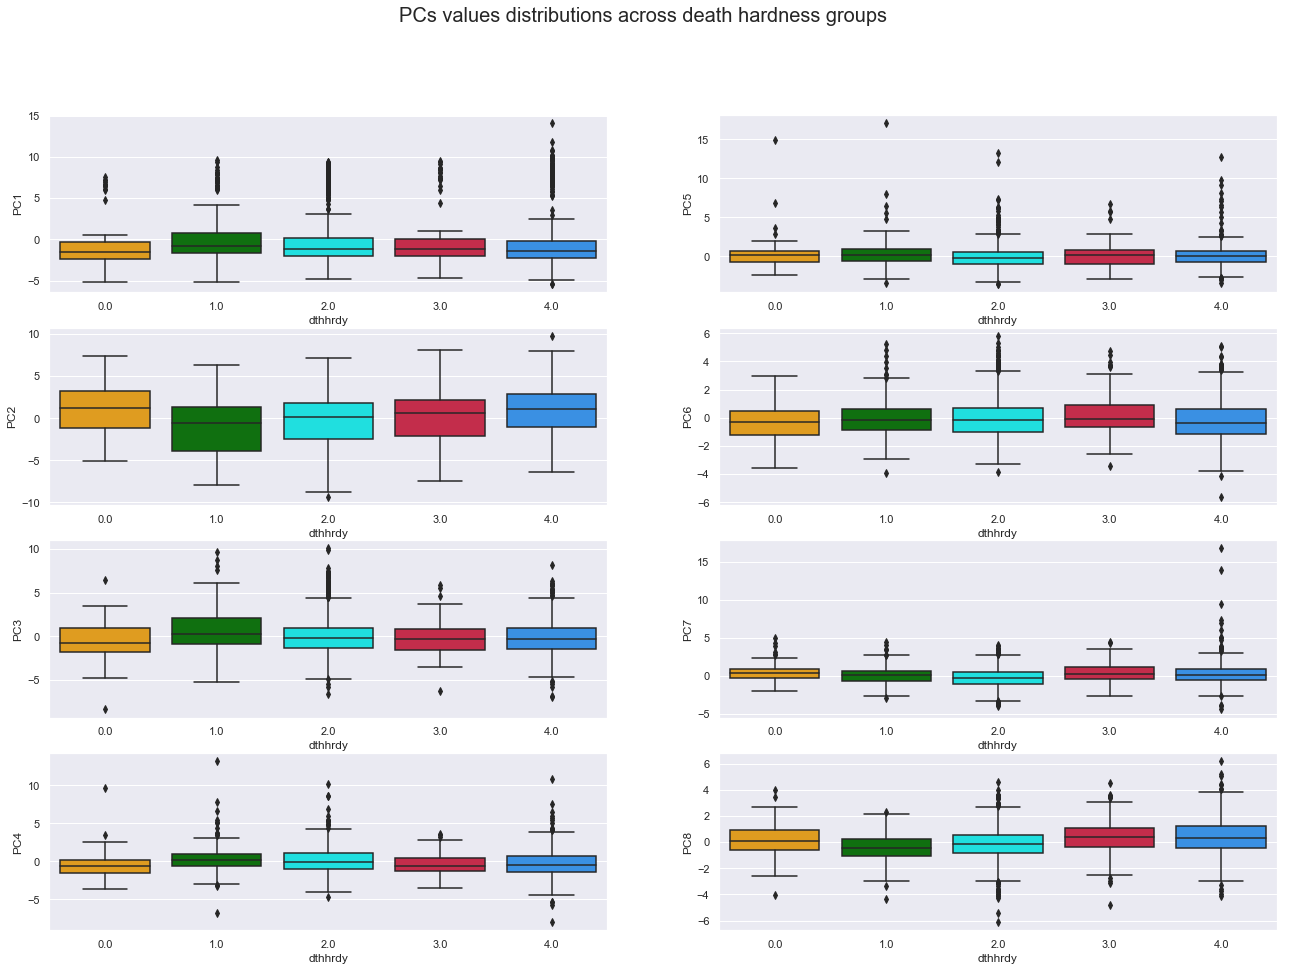

In [132]:
# Interpretation: there might be difference in PC2 across death hardness group, especially seen in cerebellum;
# datapoints of hardness = 4 (slow death after prolonged illness) and hardness = 0 (patients on ventilator immediately
# before death) are concentrated at the upper cerebellum's cluster part, whereas datapoints with hardness 2,1 are at 
# the lower part of the cluster. Boxplots for PCs expression across death hardness groups are to be generated:

print('Generating boxplots for PC distributions across death hardness levels:\n')
fig, axes = plt.subplots(4,2, figsize = (22,15)) 
plt.suptitle('PCs values distributions across death hardness groups', fontsize = 20)
i,j = 0,0

for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    sns.boxplot(x = 'dthhrdy', y = pc, data = gene_e, palette = ['orange','green','cyan','crimson','dodgerblue'],
                ax = axes[i,j])
    i += 1 
    if pc == 'PC4':
        i = 0
        j = 1
    
plt.show()

In [133]:
# Interpretation: there is an increase in PC2 across death hardness groups 2-4 (0 = on ventilator before death); there
# might also be a mild increase in PC7 and PC8 with increased death hardness (2-4); to verify these observations and
# to check how do other PCs relate to death hardness correlations are to be found (heatmap plots above only show 
# coefficients)

# death hardness has a logical meaning behind the scale 1-4 (from fast and violent to slow and natural), however 
# value 0 does not imply the hardests death, instead ir means that the subject has died being ventilated.
# To find correlations between death hardness and PCs, only death hardness values 1-4 should be taken.

print('Pearson correlations between PC distributions and death hardness (coefficient and P-value are shown):\n')

dthhrdy_subset = gene_e[(gene_e['dthhrdy'] >=1) & (gene_e['dthhrdy'] <=4)]

for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    pear, pval = stats.pearsonr(list(dthhrdy_subset['dthhrdy'].values),list(dthhrdy_subset[pc].values))
    if pval <0.05/8:
        status = 'significant'
    else:
        status = 'non-significant'
        
    print('Correlation between',pc,'and death hardness: coef =',round(pear,3),'P-value=',
          round(pval,6),'({})'.format(status))

Pearson correlations between PC distributions and death hardness (coeficient and P-value are shown):

Correlation between PC1 and death hardness: coef = -0.05 P-value= 0.034926 (non-significant)
Correlation between PC2 and death hardness: coef = 0.182 P-value= 0.0 (significant)
Correlation between PC3 and death hardness: coef = -0.081 P-value= 0.000564 (significant)
Correlation between PC4 and death hardness: coef = -0.137 P-value= 0.0 (significant)
Correlation between PC5 and death hardness: coef = 0.031 P-value= 0.182166 (non-significant)
Correlation between PC6 and death hardness: coef = -0.041 P-value= 0.08336 (non-significant)
Correlation between PC7 and death hardness: coef = 0.144 P-value= 0.0 (significant)
Correlation between PC8 and death hardness: coef = 0.189 P-value= 0.0 (significant)


In [ ]:
# Conclusion: death hardness is positively correlated with PC2, PC7, PC8 and negatively correlated with PC3, PC4.

# Q2-d: Is differential gene expression associated with ischemic time?

Testing for correlation between PCs and ischemic time; plotting PCs vs. ischemic time with highlighted brain tissues:

PC1  values are  correlated with ischemic time; Pearson rho:  0.133  P-value:  0.0 (significant)


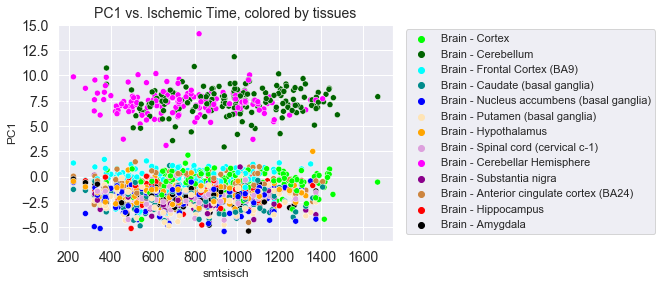

PC2  values are  correlated with ischemic time; Pearson rho:  -0.092  P-value:  6.6e-05 (significant)


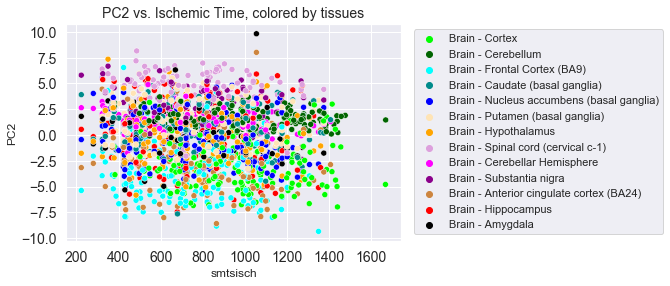

PC3  values are  correlated with ischemic time; Pearson rho:  -0.067  P-value:  0.003869 (significant)


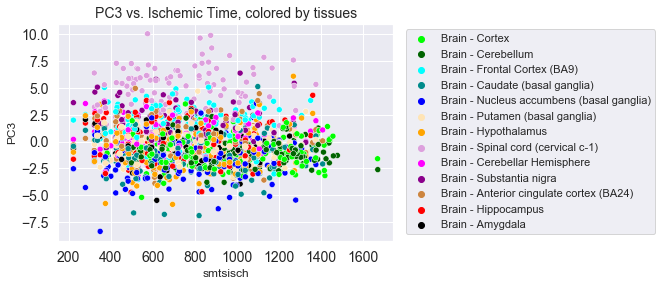

PC4  values are  non-correlated with ischemic time; Pearson rho:  -0.047  P-value:  0.041658 ()


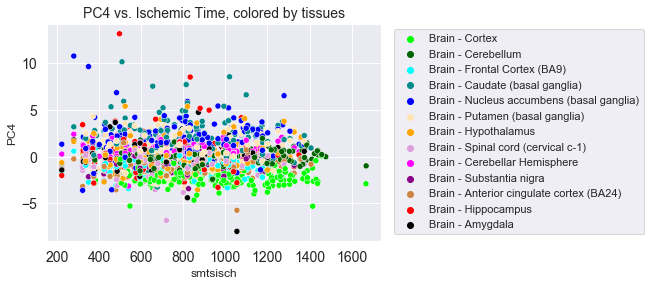

PC5  values are  non-correlated with ischemic time; Pearson rho:  -0.044  P-value:  0.059542 ()


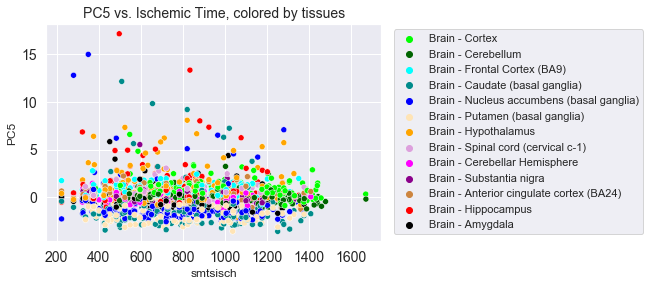

PC6  values are  correlated with ischemic time; Pearson rho:  -0.111  P-value:  1e-06 (significant)


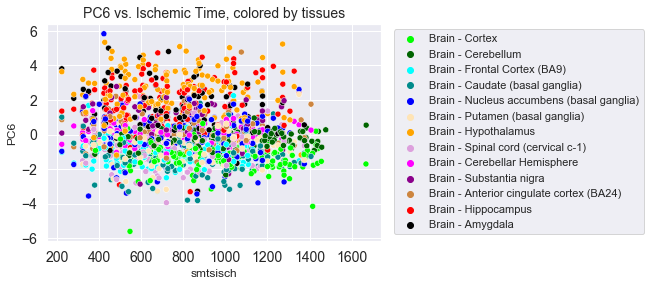

PC7  values are  correlated with ischemic time; Pearson rho:  -0.083  P-value:  0.000308 (significant)


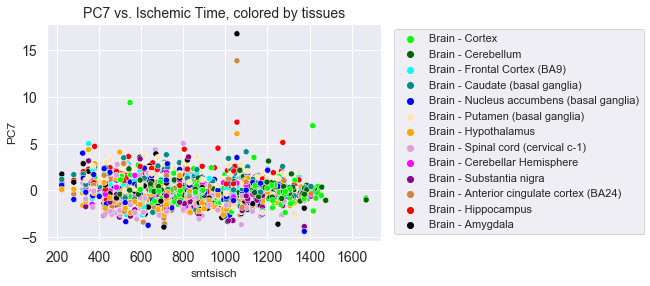

PC8  values are  non-correlated with ischemic time; Pearson rho:  -0.037  P-value:  0.108407 ()


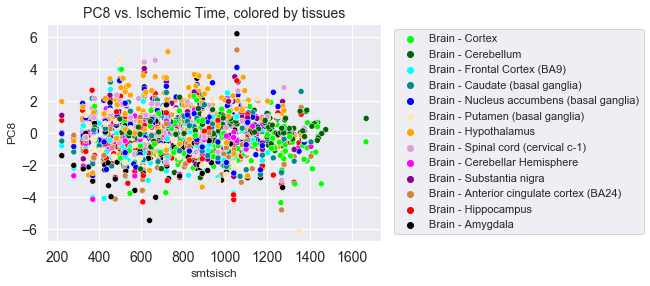

In [138]:
# For all PCs, check whether expression values are correlated with ischenic time (get P-values for correlations shown
# by heatmaps in section Q2, before detailed exploration for fetures).
# Plot gene expression vs. ischemic time using each of the PCs

cust_palette = ['lime','darkgreen','cyan','darkcyan', 'blue',
              'moccasin', 'orange', 'plum', 'magenta', 'darkmagenta',
              'peru', 'red', 'black']

print("""Testing for correlation between PCs and ischemic time; plotting PCs vs. ischemic time with highlighted brain tissues:\n""")
for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
    
    pearson_r, pearson_pval = stats.pearsonr(list(gene_e[pc].values), list(gene_e['smtsisch'].values))
    if pearson_pval < 0.05/8:  # Bonferonni correction of P-value
        status = 'correlated'
        significance_status = 'significant'
    else:
        status = 'non-correlated'
        significance_status = ''
    
    print(pc, ' values are ', status, 'with ischemic time; Pearson rho: ', round(pearson_r,3),
          ' P-value: ', round(pearson_pval,6),'({})'.format(significance_status))
        
    
    plt.figure(figsize = (6,4))
    sns.scatterplot(x = 'smtsisch', y = pc, data = gene_e, hue = 'tissue', palette = cust_palette)
    plt.title(pc+ ' vs. Ischemic Time, colored by tissues', fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(loc = 'upper right', bbox_to_anchor = (1.8,1))
    plt.show()        


In [ ]:
# Conclusion: Ischemic Time is weakly correlated (positively or negatively) with PC values, reflecting
# gene expression, except for PC4,PC5 and PC8 (these correlations have P-values > 0.05/8)

# Q3: How would STR expansions affect gene expression?

In [141]:
# First, find out whether STR length is in a linear relationship with gene expression, reflected by PCs

all_STRs = []  # there are 15 STRs in the table, generate a list of their names to be adressed in next steps
for STR_num in range(1,16):
    all_STRs.append('LargeOfTwo_STR_'+str(STR_num))
  
print('Finding correlations between STRs and 8 PCs; coefficients and P-values are shown:\n')
for one_STR in all_STRs:
    print(one_STR,':')
   
    for pc in ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']:
        pear, pval = stats.pearsonr(list(gene_e[one_STR].values),list(gene_e[pc].values))
        if pval < 0.05/120:  # Bonferonni correction for total number of tests: 15 STRs X 8 PCs = 120
            status = 'significant'
        else:
            status = 'non-significant'
            
        print('Correlation between', one_STR, 'and', pc,': coef=',
              round(pear,3),'P-value=', round(pval,6), '({})'.format(status))
    print('\n\n')

Finding correlations between STRs and 8 PCs; coeficients and P-values are shown:

LargeOfTwo_STR_1 :
Correlation between LargeOfTwo_STR_1 and PC1 : coef= -0.038 P-value= 0.09651 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC2 : coef= 0.022 P-value= 0.340804 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC3 : coef= 0.013 P-value= 0.589088 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC4 : coef= -0.005 P-value= 0.835046 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC5 : coef= 0.004 P-value= 0.863071 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC6 : coef= -0.039 P-value= 0.091153 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC7 : coef= 0.056 P-value= 0.015812 (non-significant)
Correlation between LargeOfTwo_STR_1 and PC8 : coef= 0.025 P-value= 0.279776 (non-significant)



LargeOfTwo_STR_2 :
Correlation between LargeOfTwo_STR_2 and PC1 : coef= -0.007 P-value= 0.770181 (non-significant)
Correlation between

Correlation between LargeOfTwo_STR_14 and PC3 : coef= 0.073 P-value= 0.001475 (non-significant)
Correlation between LargeOfTwo_STR_14 and PC4 : coef= 0.039 P-value= 0.087878 (non-significant)
Correlation between LargeOfTwo_STR_14 and PC5 : coef= -0.014 P-value= 0.55209 (non-significant)
Correlation between LargeOfTwo_STR_14 and PC6 : coef= 0.004 P-value= 0.862573 (non-significant)
Correlation between LargeOfTwo_STR_14 and PC7 : coef= -0.009 P-value= 0.700291 (non-significant)
Correlation between LargeOfTwo_STR_14 and PC8 : coef= 0.073 P-value= 0.001532 (non-significant)



LargeOfTwo_STR_15 :
Correlation between LargeOfTwo_STR_15 and PC1 : coef= -0.001 P-value= 0.965372 (non-significant)
Correlation between LargeOfTwo_STR_15 and PC2 : coef= -0.043 P-value= 0.060813 (non-significant)
Correlation between LargeOfTwo_STR_15 and PC3 : coef= 0.061 P-value= 0.008773 (non-significant)
Correlation between LargeOfTwo_STR_15 and PC4 : coef= 0.037 P-value= 0.110395 (non-significant)
Correlation be

In [142]:
# Interpretation:
# the following STRs (Large allele of the two) should be included in further gene expression models:
# STR_4 - correlated with PC7; STR_5 - correlated with PC8; STR_6 - correlated with PC8;
# STR_7 - correlated with PC7; STR_9 - correlated with PC7; STR_13 - correlated with PC7


Plotting PCs vs. STRs, correlating with them:



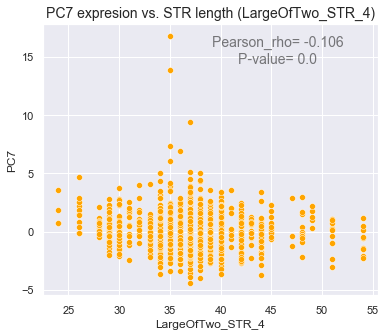

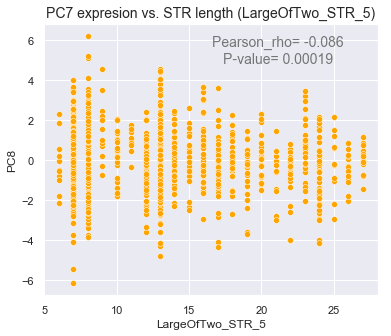

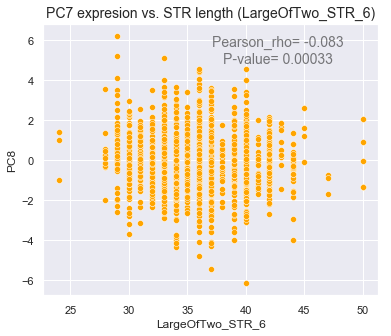

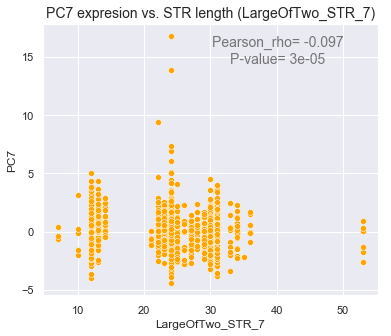

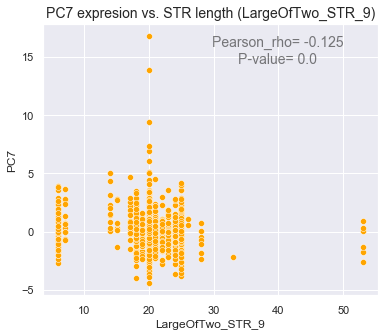

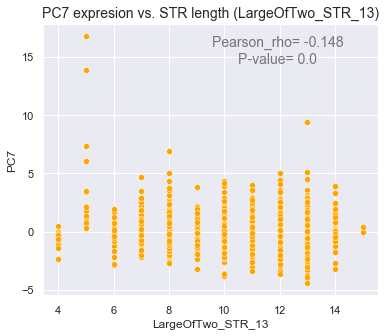

In [144]:
# Plot selected STRs vs. PCs correlated with them

print('Plotting PCs vs. STRs, correlating with them:\n')

fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_4', y = 'PC7', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.1063551867919022,3))+'\n'+'P-value= '+ str(round(4.066806758879638e-06,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_4)', fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_5', y = 'PC8', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.08607645943834666,3))+'\n'+'P-value= '+ str(round(0.00019479059127683706,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_5)', fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_6', y = 'PC8', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.0829901970698629,3))+'\n'+'P-value= '+ str(round(0.00032862467602132845,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_6)', fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_7', y = 'PC7', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.09726793068563419,3))+'\n'+'P-value= '+ str(round(2.5282990733827788e-05,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_7)', fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_9', y = 'PC7', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.12468073502435918,3))+'\n'+'P-value= '+ str(round(6.384062404021377e-08,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_9)', fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_13', y = 'PC7', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.1480928843376688,3))+'\n'+'P-value= '+ str(round(1.2464715040756262e-10,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_13)', fontsize = 14)
plt.show()




In [147]:
# Find how much STR length variation contributes to gene expression by Multiple Linear Regression,
# acounting for covariates, applicable to a particular PC.
# For PC7 response parameter, the following regressors will be included into the model: STR (4,7,9 or 13),
# ischemic time and death hardness; for PC8 response parameter, STR (5 or 6), age and death hardness will be included
# in the model as covariates.

print('Printing out coefficients and P-values found for covariates in Linear Regression models of gene expression:\n')
print('Testing PC7 expression against length of STRs (largest allele of two is used for regressions)')
PC7_covariates = ['smtsisch','dthhrdy']
for one_STR in ['LargeOfTwo_STR_4', 'LargeOfTwo_STR_7', 'LargeOfTwo_STR_9', 'LargeOfTwo_STR_13']: 
    PC7_covariates.append(one_STR)
    X = gene_e[PC7_covariates]
    X = sm.add_constant(X)
    #print(X)
    updated_covariates = list(X.columns)
    #print(updated_covariates)
    Y = gene_e[['PC7']]  
    
    fit = sm.OLS(Y,X).fit()
    
    for i in range(len(updated_covariates)):
        print(updated_covariates[i], round(list(fit.params.values)[i],3), round(list(fit.pvalues.values)[i],9)) 
    
    PC7_covariates = ['smtsisch','dthhrdy']  
    print('\n')    
print('\n')    

print('Testing PC8 expression against length of STRs (largest allele of two is used for regressions)')
PC8_covariates = ['age','dthhrdy']
for one_STR in ['LargeOfTwo_STR_5', 'LargeOfTwo_STR_6']: 
    PC8_covariates.append(one_STR)
    X = gene_e[PC8_covariates]
    X = sm.add_constant(X)
    updated_covariates = list(X.columns)
    Y = gene_e[['PC8']]
    fit = sm.OLS(Y,X).fit()
    
    for i in range(len(updated_covariates)):
        print(updated_covariates[i], round(list(fit.params.values)[i],3), round(list(fit.pvalues.values)[i],9))
   
    PC8_covariates = ['age','dthhrdy']
    
    print('\n')    
    

Printing out coefficients and P-values found for covariates in Linear Regression models of gene expression:

Testing PC7 expression against length of STRs (largest allele of two is used for regressions)
const 1.285 0.000121519
smtsisch -0.0 0.002170168
dthhrdy 0.118 0.000122209
LargeOfTwo_STR_4 -0.034 4.7931e-05


const 0.431 0.012348373
smtsisch -0.0 0.001590343
dthhrdy 0.114 0.000240838
LargeOfTwo_STR_7 -0.018 0.000468294


const 0.686 0.000265041
smtsisch -0.0 0.00545749
dthhrdy 0.118 0.000122559
LargeOfTwo_STR_9 -0.035 1.842e-06


const 1.1 2.14e-07
smtsisch -0.0 0.00053717
dthhrdy 0.119 9.4277e-05
LargeOfTwo_STR_13 -0.096 0.0




Testing PC8 expression against length of STRs (largest allele of two is used for regressions)
const -0.547 0.00211245
age 0.061 0.043324283
dthhrdy 0.194 0.0
LargeOfTwo_STR_5 -0.022 0.000140699


const 0.183 0.585485662
age 0.059 0.050819289
dthhrdy 0.189 0.0
LargeOfTwo_STR_6 -0.027 0.000982206




Generating plot for STR with the highest effect on gene expression with a trend line:



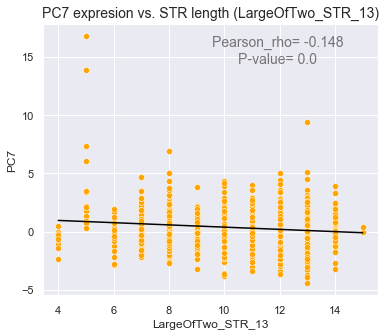

In [150]:
# Interpretation:
# Of all STRs, STR_13 seems to have the highest effect on expression (coef = -0.096); the following plot shows the line
# based on found coefficients; mild decrease in gene expression is seen with increasing STR length, however much 
# variation exists per STR length in the expression - something that cannot be explained by current set of covariates. 

print('Generating plot for STR with the highest effect on gene expression with a trend line:\n')
fig,ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(x = 'LargeOfTwo_STR_13', y = 'PC7', data = gene_e, color = 'orange')
text = 'Pearson_rho= ' + str(round(-0.1480928843376688,3))+'\n'+'P-value= '+ str(round(1.2464715040756262e-10,5))
plt.text(0.7,0.9, text, horizontalalignment='center',verticalalignment='center', fontsize=14,
         transform=ax.transAxes, alpha = 0.6)
plt.title('PC7 expresion vs. STR length (LargeOfTwo_STR_13)', fontsize = 14)

y1 =  1.099 + 0.119*2-0.096*np.min(gene_e['LargeOfTwo_STR_13'])
y2 =  1.099 + 0.119*2-0.096*np.max(gene_e['LargeOfTwo_STR_13'])
plt.plot([np.min(gene_e['LargeOfTwo_STR_13']),np.max(gene_e['LargeOfTwo_STR_13'])],
         [y1,y2], linestyle = '-',color = 'black')


plt.show()

In [ ]:
# Conclusions: 
# According to current Linear Regression models, increasing lengths of selected STR loci are associated with
# very mildly decreased expression, therefore STR expansions are likely to follow overall tendency, found for
# varying non-expanded STR lengths: 

# STR_4 is associated with a decreased gene expression, given as PC7, with coef = -0.034 and P-value = 4.8015e-05
# STR_7 is associated with a decreased gene expression, given as PC7, with coef = -0.018 and P-value = 0.000471041
# STR_9 is associated with a decreased gene expression, given as PC7, with coef = -0.035 and P-value = 1.854e-06
# STR_13 is associated with a decreased gene expression, given as PC7, with coef = -0.096 and P-value = 0.0
# STR_5 is associated with a decreased gene expression, given as PC8, with coef = -0.022 and P-value = 0.00014
# STR_6 is associated with a decreased gene expression, given as PC8, with coef = -0.027 and P-value = 0.00098

# Overall, current subsets of covariates explain only a small fraction of the expression variation; for construction 
# of a predictive model, able to calculate expression for a given STR length, it is necessary to incorporate other 
# factors, explaining most of the expression variance. Such factors may be related both to genetic backround and
# to interactions with environment (genetic variation in genes contributing to the expression of a measured target,
# single nucleotide polymorphisms, affecting initiation of the  target's expression etc.; environmental factors may 
# include any specific foods and drugs that the subjects might have been taking, their drinking and smoking history, 
# or any background illness they might have been dealing with).  
